# Microplane theory - Homogenization approaches comparison

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from math import cos, sin, pi


from numpy import array, zeros, trace, einsum, zeros_like,\
    identity, linspace, hstack, sqrt, ones
    
from traits.api import Constant, HasTraits, Property, cached_property
import traits.api as tr
import copy
import matplotlib


In [2]:
class MATS3DMicroplane(HasTraits):

    #-----------------------------------------------
    # number of microplanes
    #-----------------------------------------------
    n_mp = Constant(28)

    #-----------------------------------------------
    # get the normal vectors of the microplanes
    #-----------------------------------------------
    _MPN = Property(depends_on='n_mp')

    @cached_property
    def _get__MPN(self):
        # microplane normals:
        return array([[.577350259, .577350259, .577350259],
                      [.577350259, .577350259, -.577350259],
                      [.577350259, -.577350259, .577350259],
                      [.577350259, -.577350259, -.577350259],
                      [.935113132, .250562787, .250562787],
                      [.935113132, .250562787, -.250562787],
                      [.935113132, -.250562787, .250562787],
                      [.935113132, -.250562787, -.250562787],
                      [.250562787, .935113132, .250562787],
                      [.250562787, .935113132, -.250562787],
                      [.250562787, -.935113132, .250562787],
                      [.250562787, -.935113132, -.250562787],
                      [.250562787, .250562787, .935113132],
                      [.250562787, .250562787, -.935113132],
                      [.250562787, -.250562787, .935113132],
                      [.250562787, -.250562787, -.935113132],
                      [.186156720, .694746614, .694746614],
                      [.186156720, .694746614, -.694746614],
                      [.186156720, -.694746614, .694746614],
                      [.186156720, -.694746614, -.694746614],
                      [.694746614, .186156720, .694746614],
                      [.694746614, .186156720, -.694746614],
                      [.694746614, -.186156720, .694746614],
                      [.694746614, -.186156720, -.694746614],
                      [.694746614, .694746614, .186156720],
                      [.694746614, .694746614, -.186156720],
                      [.694746614, -.694746614, .186156720],
                      [.694746614, -.694746614, -.186156720]])

    #-------------------------------------
    # get the weights of the microplanes
    #-------------------------------------
    _MPW = Property(depends_on='n_mp')

    @cached_property
    def _get__MPW(self):
        return array([.0160714276, .0160714276, .0160714276, .0160714276, .0204744730,
                      .0204744730, .0204744730, .0204744730, .0204744730, .0204744730,
                      .0204744730, .0204744730, .0204744730, .0204744730, .0204744730,
                      .0204744730, .0158350505, .0158350505, .0158350505, .0158350505,
                      .0158350505, .0158350505, .0158350505, .0158350505, .0158350505,
                      .0158350505, .0158350505, .0158350505]) * 6.0

    #-------------------------------------------------------------------------
    # Cached elasticity tensors
    #-------------------------------------------------------------------------
    elasticity_tensor = Property(
        depends_on='E, nu, dimensionality')

    @cached_property
    def _get_elasticity_tensor(self):

        # ----------------------------------------------------------------------------
        # Lame constants calculated from E and nu
        # ----------------------------------------------------------------------------
        # first Lame paramter
        la = self.E * self.nu / ((1 + self.nu) * (1 - 2 * self.nu))
        # second Lame parameter (shear modulus)
        mu = self.E / (2 + 2 * self.nu)

        # -----------------------------------------------------------------------------------------------------
        # Get the fourth order elasticity and compliance tensors for the 2D-case
        # -----------------------------------------------------------------------------------------------------

        # construct the elasticity tensor (using Numpy - einsum function)
        delta = identity(3)
        D_ijkl = (einsum(',ij,kl->ijkl', la, delta, delta) +
                  einsum(',ik,jl->ijkl', mu, delta, delta) +
                  einsum(',il,jk->ijkl', mu, delta, delta))

        return D_ijkl

    #-------------------------------------------------------------------------
    # Setup for computation within a supplied spatial context
    #-------------------------------------------------------------------------
    D4_e = Property

    def _get_D4_e(self):
        # Return the elasticity tensor
        return self.elasticity_tensor
    

    
    
    
    
    


    #-------------------------------------------------------------------------
    '''Kinematic constraint N-T split '''
    #-------------------------------------------------------------------------

    # get the dyadic product of the microplane normals
    _MPNN = Property(depends_on='n_mp')

    @cached_property
    def _get__MPNN(self):
        # dyadic product of the microplane normals
        MPNN_nij = einsum('ni,nj->nij', self._MPN, self._MPN)
        return MPNN_nij

    # get the third order tangential tensor (operator) for each microplane
    _MPTT = Property(depends_on='n_mp')

    @cached_property
    def _get__MPTT(self):
        # Third order tangential tensor for each microplane
        delta = identity(3)
        MPTT_nijr = 0.5 * (einsum('ni,jr -> nijr', self._MPN, delta) +
                           einsum('nj,ir -> njir', self._MPN, delta) - 2 *
                           einsum('ni,nj,nr -> nijr', self._MPN, self._MPN, self._MPN))
        return MPTT_nijr

    def _get_e_N_arr(self, eps_eng):
        return einsum('nij,ij->n', self._MPNN, eps_eng)

    def _get_e_T_vct_arr(self, eps_eng):
        MPTT_ijr = self._get__MPTT()
        return einsum('nijr,ij->nr', MPTT_ijr, eps_eng)
    
    
    #-------------------------------------------------------------------------
    '''Kinematic constraint V-D-T split '''
    #-------------------------------------------------------------------------

    # get the dyadic product of the microplane normals
    _MPVV_1 = Property(depends_on='n_mp')

    @cached_property
    def _get__MPVV_1(self):
        # dyadic product of the microplane normals
        I_ij = identity(3)
        MPVV_ij = 1/3 * I_ij 
        return MPVV_ij

    
    # get the dyadic product of the microplane normals
    _MPDD_1 = Property(depends_on='n_mp')

    @cached_property
    def _get__MPDD_1(self):
        # dyadic product of the microplane normals
        I_ij = identity(3)
        MPVV_ij = 1/3 * I_ij 
        
        MPNN_nij = einsum('ni,nj->nij', self._MPN, self._MPN)
        
        MPDD_ij = einsum('nij->nij', MPNN_nij - MPVV_ij) 
        
        return MPDD_ij 

    # get the third order tangential tensor (operator) for each microplane
    _MPTT_1 = Property(depends_on='n_mp')

    @cached_property
    def _get__MPTT_1(self):
        # Third order tangential tensor for each microplane
        delta = identity(3)
        MPTT_nijr = 0.5 * (einsum('ni,jr -> nijr', self._MPN, delta) +
                           einsum('nj,ir -> njir', self._MPN, delta) - 2 *
                           einsum('ni,nj,nr -> nijr', self._MPN, self._MPN, self._MPN))
        return MPTT_nijr

    def _get_e_V1_arr(self, eps_eng):
        return einsum('ij,ij->', self._MPVV_1, eps_eng)

    def _get_e_D1_arr(self, eps_eng):
        return einsum('nij,ij->n', self._MPDD_1, eps_eng)

    def _get_e_T1_vct_arr(self, eps_eng):
        MPTT_ijr = self._get__MPTT_1()
        return einsum('nijr,ij->nr', MPTT_ijr, eps_eng)
    

    #-------------------------------------------------------------------------
    '''Kinematic constraint V-D split '''
    #-------------------------------------------------------------------------

    # get the dyadic product of the microplane normals
    _MPVV_2 = Property(depends_on='n_mp')

    @cached_property
    def _get__MPVV_2(self):
        # dyadic product of the microplane normals
        I_ij = identity(3)
        MPVV_ij = 1/3 * I_ij 
        return MPVV_ij

    # get the third order tangential tensor (operator) for each microplane
    _MPDD_2 = Property(depends_on='n_mp')

    @cached_property
    def _get__MPDD_2(self):
        # Third order tangential tensor for each microplane
        delta = identity(3)
        MPDD_nijr = 0.5 * (einsum('ni,jr -> nijr', self._MPN, delta) +
                           einsum('nj,ir -> njir', self._MPN, delta)) -\
                             1/3. * einsum('nk,ki,jr -> nijr', self._MPN, delta, delta)
        return MPDD_nijr

    def _get_e_V2_arr(self, eps_eng):
        return einsum('ij,ij->', self._MPVV_2, eps_eng)

    def _get_e_D2_vct_arr(self, eps_eng):
        MPDD_ijr = self._get__MPDD_2()
        return einsum('nijr,ij->nr', MPDD_ijr, eps_eng)
    
    
    
    
    
    
    
    
    #======================================================================================================================
    #======================================================================================================================
    '''Constitutive laws '''
    #=======================================================================================================================
    #=======================================================================================================================


    sigma_T_0 = tr.Float(200.0,
                          label="sigma_T_0",
                          desc="Reversibility limit",
                          enter_set=True,
                          auto_set=False)


    # -------------------------------------------
    # Normal_Tension constitutive law parameters (without cumulative normal strain)
    # -------------------------------------------
    Ad = tr.Float(7000.0,
                  label="A_d",
                  desc="brittleness coefficient",
                  enter_set=True,
                  auto_set=False)

    eps_0 = tr.Float(0.00002,
                     label="eps_N_0",
                     desc="threshold strain",
                     enter_set=True,
                     auto_set=False)


    # -------------------------------------------------------------------------
    # Cached elasticity tensors
    # -------------------------------------------------------------------------

    E = tr.Float(35e+3,
                 label="E",
                 desc="Young's Modulus",
                 auto_set=False,
                 input=True)

    nu = tr.Float(0.2,
                  label='nu',
                  desc="Poison ratio",
                  auto_set=False,
                  input=True)
    
    
    
    # --------------------------------------------------------------
    # microplane constitutive law (normal behavior TD)
    # --------------------------------------------------------------
    def get_normal_law(self, eps_N_Emn, sctx):
        
        sigma_N_Emn = sctx[:, 0]
        omega_N_Emn = sctx[:, 1]
        r_N_Emn = sctx[:, 2]

        E_N = self.E / (1.0 - 2.0 * self.nu)

        # When deciding if a microplane is in tensile or compression,
        # we define a strain boundary such that
        # sigmaN <= 0 if eps_N < 0, avoiding entering in the quadrant
        # of compressive strains and traction

#         sigma_trial = E_N * (eps_N_Emn)
#         # looking for microplanes violating strain boundary
#         pos1 = [(eps_N_Emn < -1e-6) & (sigma_trial > 1e-6)]
#         sigma_trial[pos1[0]] = 0
        pos = eps_N_Emn > 1e-6  # microplanes under traction
        pos2 = eps_N_Emn < -1e-6  # microplanes under compression
        H = 1.0 * pos
        H2 = 1.0 * pos2

        # thermo forces
        #sigma_N_Emn_tilde = E_N * (eps_N_Emn)
        #sigma_N_Emn_tilde[pos1[0]] = 0  # imposing strain boundary


        def R_N(r_N_Emn): return (1.0 / self.Ad) * (-r_N_Emn / (1.0 + r_N_Emn))

        Y_N = 0.5 * H * E_N * (eps_N_Emn) ** 2.0
        Y_0 = 0.5 * E_N * self.eps_0 ** 2.0

        f = (Y_N - (Y_0 + R_N(r_N_Emn)))

        # threshold damage

        thres_2 = f > 1e-6

        def f_w(Y): return 1.0 - 1.0 / (1.0 + self.Ad * (Y - Y_0))

        omega_N_Emn[f > 1e-6] = f_w(Y_N)[f > 1e-6]
        #omega_N_Emn = f_w(Y_N)
        #omega_N_Emn[...] = np.clip(omega_N_Emn,0,0.9999)
        r_N_Emn[f > 1e-6] = -omega_N_Emn[f > 1e-6]
        #r_N_Emn = -omega_N_Emn

        sigma_N_Emn = (1.0 -  H *  omega_N_Emn) * E_N * (eps_N_Emn)
        #pos1 = [(eps_N_Emn < -1e-6) & (sigma_trial > 1e-6)]  # looking for microplanes violating strain boundary
        #sigma_N_Emn[pos1[0]] = 0
        
        
        
        
        
        

#         def Z_N(z_N): return 1. / self.Ad * (-z_N) / (1. + z_N)
#         Y_N = 0.5 * H * E_N * eps ** 2.
#         Y_0 = 0.5 * E_N * self.eps_0 ** 2.
#         f = Y_N - (Y_0 + Z_N(z_N))

#         thres_2 = f > 1e-6

#         def f_w(Y): return 1. - 1. / (1. + self.Ad * (Y - Y_0))
#         w_N = f_w(Y_N) * thres_2
#         z_N = - w_N * thres_2

        new_sctx = zeros((28, 3))
        new_sctx[:, 0] = sigma_N_Emn
        new_sctx[:, 1] = omega_N_Emn
        new_sctx[:, 2] = r_N_Emn
        
        return new_sctx

    
    # -------------------------------------------------------------------------
    # microplane constitutive law (Tangential TP)-(Pure plasticity)
    # -------------------------------------------------------------------------
    def get_tangential_law(self, eps_T_Emna, sctx):
        
        sigma_T_Emna = sctx[:, 3:6]
        eps_T_pi_Emna = sctx[:, 6:9]

        E_T = self.E * (1.0 - 4 * self.nu) / \
            ((1.0 + self.nu) * (1.0 - 2 * self.nu))

        # thermo forces

        sig_pi_trial = E_T * (eps_T_Emna - eps_T_pi_Emna)

        norm_1 = np.sqrt(
            np.einsum(
                '...na,...na->...n',
                (sig_pi_trial), (sig_pi_trial ))
        )

        # threshold

        f = norm_1 - self.sigma_T_0 

        plas_1 = f > 1e-6
        elas_1 = f < 1e-6

        delta_lamda = f / (E_T ) * plas_1

        norm_2 = 1.0 * elas_1 + np.sqrt(np.einsum(
                '...na,...na->...n',
                (sig_pi_trial ), (sig_pi_trial ))) * plas_1

        eps_T_pi_Emna[..., 0] += plas_1 * delta_lamda * (sig_pi_trial[..., 0] ) / norm_2
        eps_T_pi_Emna[..., 1] += plas_1 * delta_lamda * (sig_pi_trial[..., 1] ) / norm_2
        eps_T_pi_Emna[..., 2] += plas_1 * delta_lamda * (sig_pi_trial[..., 2] ) / norm_2



        sigma_T_Emna = np.einsum('...na->...na', E_T * (eps_T_Emna - eps_T_pi_Emna))

        new_sctx = zeros((28, 6))
        new_sctx[:, 0:3] = sigma_T_Emna
        new_sctx[:, 3:6] = eps_T_pi_Emna
        
        return new_sctx 
    
    
    def get_state_variables(self, eps_Emab, sctx):

        eps_N_Emn = self._get_e_N_arr(eps_Emab)
        eps_T_Emna = self._get_e_T_vct_arr(eps_Emab)

        sctx_arr = zeros_like(sctx)

        sctx_N = self.get_normal_law(eps_N_Emn, sctx)
        sctx_arr[:, 0:3] = sctx_N

        sctx_T = self.get_tangential_law(eps_T_Emna, sctx)
        sctx_arr[:, 3:9] = sctx_T

        return sctx_arr
    
    #=====================================================================================================================
    #=====================================================================================================================
    '''Homogenization'''
    #======================================================================================================================
    #======================================================================================================================
    
    #-------------------------------------------------------------------------
    '''Energy equivalent (EEQ)'''
    #-------------------------------------------------------------------------
        #DELTA = np.identity(3)
        
         # Rank four integrity tensor
    def _get_beta_Emabcd_1(self, eps_Emab, sctx):
        '''
        Returns the 4th order damage tensor 'beta4' using sum-type symmetrization
        (cf. [Jir99], Eq.(21))
        '''
        delta = identity(3)
        
        eps_N_Emn = self._get_e_N_arr(eps_Emab)
        eps_T_Emna = self._get_e_T_vct_arr(eps_Emab)

        omega_N_Emn = self.get_state_variables(eps_Emab, sctx)[:, 1]
        
        
        
        phi_N = np.sqrt(1. - omega_N_Emn)
        
        phi_ij = einsum('n,n,nij->ij', phi_N, self._MPW, self._MPNN)

        # use numpy functionality (einsum) to evaluate [Jir99], Eq.(21)
        beta_ijkl = 0.25 * (einsum('ik,jl->ijkl', phi_ij , delta) +
                            einsum('il,jk->ijkl', phi_ij , delta) +
                            einsum('jk,il->ijkl', phi_ij , delta) +
                            einsum('jl,ik->ijkl', phi_ij , delta))

        return beta_ijkl
    
        
         # Rank four integrity tensor
    def _get_beta_Emabcd_2(self, eps_Emab, sctx):
        # Returns the 4th order damage tensor 'beta4' using
        # (cf. [Baz99], Eq.(63))

        eps_N_Emn = self._get_e_N_arr(eps_Emab)
        eps_T_Emna = self._get_e_T_vct_arr(eps_Emab)
        delta = identity(3)

        omega_N_Emn = self.get_state_variables(eps_Emab , sctx)[:, 1]


        beta_N = np.sqrt(1. - omega_N_Emn)
        beta_T = np.sqrt(1. - np.zeros_like(omega_N_Emn))
        #beta_T = beta_N

        beta_ijkl = np.einsum('n, ...n,ni, nj, nk, nl -> ...ijkl', self._MPW, beta_N, self._MPN, self._MPN, self._MPN,
                              self._MPN) + \
                    0.25 * (np.einsum('n, ...n,ni, nk, jl -> ...ijkl', self._MPW, beta_T, self._MPN, self._MPN, delta) +
                            np.einsum('n, ...n,ni, nl, jk -> ...ijkl', self._MPW, beta_T, self._MPN, self._MPN, delta) +
                            np.einsum('n, ...n,nj, nk, il -> ...ijkl', self._MPW, beta_T, self._MPN, self._MPN, delta) +
                            np.einsum('n, ...n,nj, nl, ik -> ...ijkl', self._MPW, beta_T, self._MPN, self._MPN, delta) -
                            4.0 * np.einsum('n, ...n, ni, nj, nk, nl -> ...ijkl', self._MPW, beta_T, self._MPN,
                                            self._MPN, self._MPN, self._MPN))

        return beta_ijkl
    

    
        # Plastic strain tensor
    def _get_eps_p_Emab(self, eps_Emab, sctx):
        
        eps_N_Emn = self._get_e_N_arr(eps_Emab)
        eps_T_Emna = self._get_e_T_vct_arr(eps_Emab)
        delta = identity(3)
        
        eps_N_p_Emn = np.zeros_like(eps_N_Emn)

        # sliding tangential strains
        eps_T_pi_Emna  = self.get_state_variables(eps_Emab , sctx)[:, 6:9]

        # 2-nd order plastic (inelastic) tensor
        eps_p_Emab = (
                np.einsum('n,...n,na,nb->...ab',
                          self._MPW, eps_N_p_Emn, self._MPN, self._MPN) +
                0.5 * (
                        np.einsum('n,...nf,na,fb->...ab',
                                  self._MPW, eps_T_pi_Emna, self._MPN, delta) +
                        np.einsum('n,...nf,nb,fa->...ab',
                                  self._MPW, eps_T_pi_Emna, self._MPN, delta)
                )
        )

        return eps_p_Emab
    
    
    
    
    def get_corr_pred_EEQ_1(self, eps_Emab, sctx):

        # ------------------------------------------------------------------
        # Damaged stiffness tensor calculated based on the damage tensor beta4:
        # ------------------------------------------------------------------
        beta_Emabcd = self._get_beta_Emabcd_1(eps_Emab, sctx)
        D_Emabcd = np.einsum('...ijab, abef, ...cdef->...ijcd', beta_Emabcd, self.D4_e , beta_Emabcd)

        # ----------------------------------------------------------------------
        # Return stresses (corrector) and damaged secant stiffness matrix (predictor)
        # ----------------------------------------------------------------------
        # plastic strain tensor
        eps_p_Emab = self._get_eps_p_Emab(eps_Emab, sctx)

        # elastic strain tensor
        eps_e_Emab = eps_Emab - eps_p_Emab

        # calculation of the stress tensor
        sig_Emab = np.einsum('...abcd,...cd->...ab', D_Emabcd, eps_e_Emab)

        return sig_Emab, D_Emabcd
    
    
    def get_corr_pred_EEQ_2(self, eps_Emab, sctx):

        # ------------------------------------------------------------------
        # Damaged stiffness tensor calculated based on the damage tensor beta4:
        # ------------------------------------------------------------------
        beta_Emabcd = self._get_beta_Emabcd_2(eps_Emab, sctx)
        #print(beta_Emabcd.shape)
        #print(self.D4_e )
        D_Emabcd = np.einsum('...ijab, abef, ...cdef->...ijcd', beta_Emabcd, self.D4_e , beta_Emabcd)

        # ----------------------------------------------------------------------
        # Return stresses (corrector) and damaged secant stiffness matrix (predictor)
        # ----------------------------------------------------------------------
        # plastic strain tensor
        eps_p_Emab = self._get_eps_p_Emab(eps_Emab, sctx)

        # elastic strain tensor
        eps_e_Emab = eps_Emab - eps_p_Emab

        # calculation of the stress tensor
        sig_Emab = np.einsum('...abcd,...cd->...ab', D_Emabcd, eps_e_Emab)

        return sig_Emab, D_Emabcd
    
    
    #-------------------------------------------------------------------------
    '''Principle of Virtual work (PVW)'''
    #-------------------------------------------------------------------------
        
    def get_corr_pred_PVW(self, eps_Emab, sctx):
    
        eps_N_Emn = self._get_e_N_arr(eps_Emab)
        eps_T_Emna = self._get_e_T_vct_arr(eps_Emab)

        sigma_N_Emn = self.get_state_variables(eps_Emab , sctx)[:, 0]

        sigma_T_Emna= self.get_state_variables(eps_Emab, sctx)[:, 3:6]
        
        sigma_Emab = einsum('n, nij, ...n -> ...ij', self._MPW, self._MPNN, sigma_N_Emn) + \
            einsum('n, nkij, ...nk -> ...ij', self._MPW, self._MPTT, sigma_T_Emna)
    
        return sigma_Emab
    
    #-------------------------------------------------------------------------
    '''Orintation distribution functions (ODFs)'''
    #-------------------------------------------------------------------------
    
    
    
    
    
    

In [15]:
class MATS3DMplCSDEEQ(HasTraits):
    concrete_type = tr.Int

    gamma_T = tr.Float(00000.,
                       label="Gamma",
                       desc=" Tangential Kinematic hardening modulus",
                       enter_set=True,
                       auto_set=False)

    K_T = tr.Float(0000.,
                   label="K",
                   desc="Tangential Isotropic harening",
                   enter_set=True,
                   auto_set=False)

    S_T = tr.Float(0.005,
                   label="S",
                   desc="Damage strength",
                   enter_set=True,
                   auto_set=False)

    r_T = tr.Float(9.,
                   label="r",
                   desc="Damage cumulation parameter",
                   enter_set=True,
                   auto_set=False)
    e_T = tr.Float(12.,
                   label="e",
                   desc="Damage cumulation parameter",
                   enter_set=True,
                   auto_set=False)

    c_T = tr.Float(4.6,
                   label="c",
                   desc="Damage cumulation parameter",
                   enter_set=True,
                   auto_set=False)

    tau_pi_bar = tr.Float(1.,
                          label="Tau_bar",
                          desc="Reversibility limit",
                          enter_set=True,
                          auto_set=False)

    a = tr.Float(0.003,
                 label="a",
                 desc="Lateral pressure coefficient",
                 enter_set=True,
                 auto_set=False)

    # -------------------------------------------
    # Normal_Tension constitutive law parameters (without cumulative normal strain)
    # -------------------------------------------
    Ad = tr.Float(7000.0,
                  label="a",
                  desc="brittleness coefficient",
                  enter_set=True,
                  auto_set=False)

    eps_0 = tr.Float(0.00002,
                     label="a",
                     desc="threshold strain",
                     enter_set=True,
                     auto_set=False)

    # -----------------------------------------------
    # Normal_Compression constitutive law parameters
    # -----------------------------------------------
    K_N = tr.Float(10000.,
                   label="K_N",
                   desc=" Normal isotropic harening",
                   enter_set=True,
                   auto_set=False)

    gamma_N = tr.Float(5000.,
                       label="gamma_N",
                       desc="Normal kinematic hardening",
                       enter_set=True,
                       auto_set=False)

    sigma_0 = tr.Float(30.,
                       label="sigma_0",
                       desc="Yielding stress",
                       enter_set=True,
                       auto_set=False)

    # -------------------------------------------------------------------------
    # Cached elasticity tensors
    # -------------------------------------------------------------------------

    E = tr.Float(35e+3,
                 label="E",
                 desc="Young's Modulus",
                 auto_set=False,
                 input=True)

    nu = tr.Float(0.2,
                  label='nu',
                  desc="Poison ratio",
                  auto_set=False,
                  input=True)

    # --------------------------------------------------------------
    # microplane constitutive law (normal behavior CP + TD)
    # --------------------------------------------------------------
    def get_normal_law(self, eps_N_Emn, omega_N_Emn, z_N_Emn,
                       alpha_N_Emn, r_N_Emn, eps_N_p_Emn, eps_aux):

        E_N = self.E / (1.0 - 2.0 * self.nu)

        # When deciding if a microplane is in tensile or compression, we define a strain boundary such that that
        # sigmaN <= 0 if eps_N < 0, avoiding entering in the quadrant of compressive strains and traction

        sigma_trial = E_N * (eps_N_Emn - eps_N_p_Emn)
        pos1 = [(eps_N_Emn < -1e-6) & (sigma_trial > 1e-6)]  # looking for microplanes violating strain boundary
        sigma_trial[pos1[0]] = 0
        pos = sigma_trial > 1e-6  # microplanes under traction
        pos2 = sigma_trial < -1e-6  # microplanes under compression
        H = 1.0 * pos
        H2 = 1.0 * pos2

        # thermo forces
        sigma_N_Emn_tilde = E_N * (eps_N_Emn - eps_N_p_Emn)
        sigma_N_Emn_tilde[pos1[0]] = 0  # imposing strain boundary

        Z = self.K_N * z_N_Emn
        X = self.gamma_N * alpha_N_Emn * H2
        h = (self.sigma_0 + Z) * H2

        f_trial = (abs(sigma_N_Emn_tilde - X) - h) * H2

        # threshold plasticity

#         thres_1 = f_trial > 1e-6

#         delta_lamda = f_trial / \
#                       (E_N / (1 - omega_N_Emn) + abs(self.K_N) + self.gamma_N) * thres_1
#         eps_N_p_Emn = eps_N_p_Emn + delta_lamda * \
#                       np.sign(sigma_N_Emn_tilde - X)
#         z_N_Emn = z_N_Emn + delta_lamda
#         alpha_N_Emn = alpha_N_Emn + delta_lamda * \
#                       np.sign(sigma_N_Emn_tilde - X)

        def R_N(r_N_Emn): return (1.0 / self.Ad) * (-r_N_Emn / (1.0 + r_N_Emn))

        Y_N = 0.5 * H * E_N * (eps_N_Emn - eps_N_p_Emn) ** 2.0
        Y_0 = 0.5 * E_N * self.eps_0 ** 2.0

        f = (Y_N - (Y_0 + R_N(r_N_Emn)))

        # threshold damage

        thres_2 = f > 1e-6

        def f_w(Y): return 1.0 - 1.0 / (1.0 + self.Ad * (Y - Y_0))

        omega_N_Emn[f > 1e-6] = f_w(Y_N)[f > 1e-6]
        r_N_Emn[f > 1e-6] = -omega_N_Emn[f > 1e-6]

        sigma_N_Emn = (1.0 - H * omega_N_Emn) * E_N * (eps_N_Emn - eps_N_p_Emn)
        pos1 = [(eps_N_Emn < -1e-6) & (sigma_trial > 1e-6)]  # looking for microplanes violating strain boundary

        R_N = (1.0 / self.Ad) * (-r_N_Emn / (1.0 + r_N_Emn))

        Z = self.K_N * z_N_Emn
        X = self.gamma_N * alpha_N_Emn * H2

        return omega_N_Emn, z_N_Emn, alpha_N_Emn, r_N_Emn, eps_N_p_Emn, sigma_N_Emn, Z, X, Y_N, R_N

    # -------------------------------------------------------------------------
    # microplane constitutive law (Tangential CSD)-(Pressure sensitive cumulative damage)
    # -------------------------------------------------------------------------
    def get_tangential_law(self, eps_T_Emna, omega_T_Emn, z_T_Emn,
                           alpha_T_Emna, eps_T_pi_Emna, sigma_N_Emn):

        E_T = self.E * (1.0 - 4 * self.nu) / \
              ((1.0 + self.nu) * (1.0 - 2 * self.nu))

        # thermo forces

        sig_pi_trial = E_T * (eps_T_Emna - eps_T_pi_Emna)

        Z = self.K_T * z_T_Emn
        X = self.gamma_T * alpha_T_Emna
        norm_1 = np.sqrt(
            np.einsum(
                '...na,...na->...n',
                (sig_pi_trial - X), (sig_pi_trial - X))
        )
        Y = 0.5 * E_T * \
            np.einsum(
                '...na,...na->...n',
                (eps_T_Emna - eps_T_pi_Emna),
                (eps_T_Emna - eps_T_pi_Emna))

        # threshold

        f = norm_1 - self.tau_pi_bar - \
            Z + self.a * sigma_N_Emn

        plas_1 = f > 1e-6
        elas_1 = f < 1e-6

        delta_lamda = f / \
                      (E_T / (1.0 - omega_T_Emn) + self.gamma_T + self.K_T) * plas_1

        norm_2 = 1.0 * elas_1 + np.sqrt(
            np.einsum(
                '...na,...na->...n',
                (sig_pi_trial - X), (sig_pi_trial - X))) * plas_1

        eps_T_pi_Emna[..., 0] = eps_T_pi_Emna[..., 0] + plas_1 * delta_lamda * \
                                ((sig_pi_trial[..., 0] - X[..., 0]) /
                                 (1.0 - omega_T_Emn)) / norm_2
        eps_T_pi_Emna[..., 1] = eps_T_pi_Emna[..., 1] + plas_1 * delta_lamda * \
                                ((sig_pi_trial[..., 1] - X[..., 1]) /
                                 (1.0 - omega_T_Emn)) / norm_2
        eps_T_pi_Emna[..., 2] = eps_T_pi_Emna[..., 2] + plas_1 * delta_lamda * \
                                ((sig_pi_trial[..., 2] - X[..., 2]) /
                                 (1.0 - omega_T_Emn)) / norm_2

#         omega_T_Emn += ((1.0 - omega_T_Emn) ** self.c_T) * \
#                        (delta_lamda * (Y / self.S_T) ** self.r_T) * \
#                        (self.tau_pi_bar / (self.tau_pi_bar - self.a * sigma_N_Emn)) ** self.e_T

#         alpha_T_Emna[..., 0] = alpha_T_Emna[..., 0] + plas_1 * delta_lamda * \
#                                (sig_pi_trial[..., 0] - X[..., 0]) / norm_2
#         alpha_T_Emna[..., 1] = alpha_T_Emna[..., 1] + plas_1 * delta_lamda * \
#                                (sig_pi_trial[..., 1] - X[..., 1]) / norm_2
#         alpha_T_Emna[..., 2] = alpha_T_Emna[..., 2] + plas_1 * delta_lamda * \
#                                (sig_pi_trial[..., 2] - X[..., 2]) / norm_2
#         z_T_Emn = z_T_Emn + delta_lamda

        sigma_T_Emna = np.einsum(
            '...n,...na->...na', (1 - omega_T_Emn), E_T * (eps_T_Emna - eps_T_pi_Emna))

        Z = self.K_T * z_T_Emn
        X = self.gamma_T * alpha_T_Emna
        Y = 0.5 * E_T * \
            np.einsum(
                '...na,...na->...n',
                (eps_T_Emna - eps_T_pi_Emna),
                (eps_T_Emna - eps_T_pi_Emna))

        return omega_T_Emn, z_T_Emn, alpha_T_Emna, eps_T_pi_Emna, sigma_T_Emna, Z, X, Y



    # -------------------------------------------------------------------------
    # MICROPLANE-Kinematic constraints
    # -------------------------------------------------------------------------
    # get the operator of the microplane normals
    _MPNN = tr.Property(depends_on='n_mp')

    @tr.cached_property
    def _get__MPNN(self):
        MPNN_nij = np.einsum('ni,nj->nij', self._MPN, self._MPN)
        return MPNN_nij

    # get the third order tangential tensor (operator) for each microplane
    _MPTT = tr.Property(depends_on='n_mp')

    @tr.cached_property
    def _get__MPTT(self):
        delta = np.identity(3)
        MPTT_nijr = 0.5 * (
                np.einsum('ni,jr -> nijr', self._MPN, delta) +
                np.einsum('nj,ir -> njir', self._MPN, delta) - 2 *
                np.einsum('ni,nj,nr -> nijr', self._MPN, self._MPN, self._MPN)
        )
        return MPTT_nijr

    def _get_e_N_Emn_2(self, eps_Emab):
        # get the normal strain array for each microplane
        return np.einsum('nij,...ij->...n', self._MPNN, eps_Emab)

    def _get_e_T_Emnar_2(self, eps_Emab):
        # get the tangential strain vector array for each microplane
        MPTT_ijr = self._get__MPTT()
        return np.einsum('nija,...ij->...na', MPTT_ijr, eps_Emab)

    # --------------------------------------------------------
    # return the state variables (Damage , inelastic strains)
    # --------------------------------------------------------
    def _x_get_state_variables(self, eps_Emab,
                             int_var, eps_aux):

        e_N_arr = self._get_e_N_Emn_2(eps_Emab)
        e_T_vct_arr = self._get_e_T_Emnar_2(eps_Emab)

        omega_N_Emn = int_var[:, 0]
        z_N_Emn = int_var[:, 1]
        alpha_N_Emn = int_var[:, 2]
        r_N_Emn = int_var[:, 3]
        eps_N_p_Emn = int_var[:, 4]
        sigma_N_Emn = int_var[:, 5]

        omega_T_Emn = int_var[:, 9]
        z_T_Emn = int_var[:, 10]
        alpha_T_Emna = int_var[:, 11:14]
        eps_T_pi_Emna = int_var[:, 14:17]
        omega_N_Emn, z_N_Emn, alpha_N_Emn, r_N_Emn, eps_N_p_Emn, sigma_N_Emn, Z_n, X_n, Y_n, R_n = self.get_normal_law(
            e_N_arr, omega_N_Emn, z_N_Emn,
            alpha_N_Emn, r_N_Emn, eps_N_p_Emn, eps_aux)

        omega_T_Emn, z_T_Emn, alpha_T_Emna, eps_T_pi_Emna, sigma_T_Emna, Z_T, X_T, Y_T = self.get_tangential_law(
            e_T_vct_arr, omega_T_Emn, z_T_Emn, alpha_T_Emna, eps_T_pi_Emna, sigma_N_Emn)

        # Definition internal variables / forces per column:  1) damage N, 2)iso N, 3)kin N, 4) consolidation N, 5) eps p N,
        # 6) sigma N, 7) iso F N, 8) kin F N, 9) energy release N, 10) damage T, 11) iso T, 12-14) kin T, 15-17) eps p T,
        # 18-20) sigma T, 21) iso F T, 22-24) kin F T, 25) energy release T, 26) eps_N, 27-29) e_T, 30)R_n

        int_var[:, 0] = omega_N_Emn
        int_var[:, 1] = z_N_Emn
        int_var[:, 2] = alpha_N_Emn
        int_var[:, 3] = r_N_Emn
        int_var[:, 4] = eps_N_p_Emn
        int_var[:, 5] = sigma_N_Emn
        int_var[:, 6] = Z_n
        int_var[:, 7] = X_n
        int_var[:, 8] = Y_n

        int_var[:, 9] = omega_T_Emn
        int_var[:, 10] = z_T_Emn
        int_var[:, 11:14] = alpha_T_Emna
        int_var[:, 14:17] = eps_T_pi_Emna
        int_var[:, 17:20] = sigma_T_Emna
        int_var[:, 20] = Z_T
        int_var[:, 21:24] = X_T
        int_var[:, 24] = Y_T

        int_var[:, 25] = e_N_arr
        int_var[:, 26:29] = e_T_vct_arr
        int_var[:, 29] = R_n

        return int_var

        # ---------------------------------------------------------------------
        # Extra homogenization of damage tensor in case of two damage parameters
        # Returns the 4th order damage tensor 'beta4' using (ref. [Baz99], Eq.(63))
        # ---------------------------------------------------------------------
        
    def _get_beta_Emabcd_1(self, eps_Emab, omega_N_Emn, omega_T_Emn):
        '''
        Returns the 4th order damage tensor 'beta4' using sum-type symmetrization
        (cf. [Jir99], Eq.(21))
        '''
        delta = identity(3)        
        
        phi_N = np.sqrt(1. - omega_N_Emn)
        
        phi_ij = einsum('n,n,nij->ij', phi_N, self._MPW, self._MPNN)

        # use numpy functionality (einsum) to evaluate [Jir99], Eq.(21)
        beta_ijkl = 0.25 * (einsum('ik,jl->ijkl', phi_ij , delta) +
                            einsum('il,jk->ijkl', phi_ij , delta) +
                            einsum('jk,il->ijkl', phi_ij , delta) +
                            einsum('jl,ik->ijkl', phi_ij , delta))

        return beta_ijkl

    def _get_beta_Emabcd_2(self, eps_Emab, omega_N_Emn, z_N_Emn,
                           alpha_N_Emn, r_N_Emn, eps_N_p_Emn, omega_T_Emn, z_T_Emn,
                           alpha_T_Emna, eps_T_pi_Emna, eps_aux):
        # Returns the 4th order damage tensor 'beta4' using
        # (cf. [Baz99], Eq.(63))

        delta = np.identity(3)
        beta_N = np.sqrt(1. - omega_N_Emn)
        beta_T = np.sqrt(1. - omega_T_Emn)

        beta_ijkl = np.einsum('n, ...n,ni, nj, nk, nl -> ...ijkl', self._MPW, beta_N, self._MPN, self._MPN,
                              self._MPN, self._MPN) + \
                    0.25 * (np.einsum('n, ...n,ni, nk, jl -> ...ijkl', self._MPW, beta_T, self._MPN, self._MPN,
                                      delta) +
                            np.einsum('n, ...n,ni, nl, jk -> ...ijkl', self._MPW, beta_T, self._MPN, self._MPN,
                                      delta) +
                            np.einsum('n, ...n,nj, nk, il -> ...ijkl', self._MPW, beta_T, self._MPN, self._MPN,
                                      delta) +
                            np.einsum('n, ...n,nj, nl, ik -> ...ijkl', self._MPW, beta_T, self._MPN, self._MPN,
                                      delta) -
                            4.0 * np.einsum('n, ...n, ni, nj, nk, nl -> ...ijkl', self._MPW, beta_T, self._MPN,
                                            self._MPN, self._MPN, self._MPN))

        return beta_ijkl

    # -----------------------------------------------------------
    # Integration of the (inelastic) strains for each microplane
    # -----------------------------------------------------------

    def _get_eps_p_Emab(self, eps_Emab, omega_N_Emn, z_N_Emn,
                        alpha_N_Emn, r_N_Emn, eps_N_p_Emn,
                        omega_T_Emn, z_T_Emn, alpha_T_Emna, eps_T_pi_Emna, sigma_N_Emn, eps_aux):

        delta = np.identity(3)

        # 2-nd order plastic (inelastic) tensor
        eps_p_Emab = (
                np.einsum('n,...n,na,nb->...ab',
                          self._MPW, eps_N_p_Emn, self._MPN, self._MPN) +
                0.5 * (
                        np.einsum('n,...nf,na,fb->...ab',
                                  self._MPW, eps_T_pi_Emna, self._MPN, delta) +
                        np.einsum('n,...nf,nb,fa->...ab', self._MPW,
                                  eps_T_pi_Emna, self._MPN, delta)
                )
        )

        return eps_p_Emab

    # -------------------------------------------------------------------------
    # Evaluation - get the corrector and predictor
    # -------------------------------------------------------------------------
    
    

    def get_corr_pred_EEQ_1(self, eps_Emab, t_n1, int_var, eps_aux, F):
        # Definition internal variables / forces per column:  1) damage N, 2)iso N, 3)kin N, 4)consolidation N, 5) eps p N,
        # 6) sigma N, 7) iso F N, 8) kin F N, 9) energy release N, 10) damage T, 11) iso T, 12-13) kin T, 14-15) eps p T,
        # 16-17) sigma T, 18) iso F T, 19-20) kin F T, 21) energy release T

        # Corrector predictor computation.

        # ------------------------------------------------------------------
        # Damage tensor (4th order) using product- or sum-type symmetrization:
        # ------------------------------------------------------------------

        eps_N_Emn = self._get_e_N_Emn_2(eps_Emab)
        eps_T_Emna = self._get_e_T_Emnar_2(eps_Emab)

        omega_N_Emn = int_var[:, 0]
        z_N_Emn = int_var[:, 1]
        alpha_N_Emn = int_var[:, 2]
        r_N_Emn = int_var[:, 3]
        eps_N_p_Emn = int_var[:, 4]
        sigma_N_Emn = int_var[:, 5]

        omega_T_Emn = int_var[:, 9]
        z_T_Emn = int_var[:, 10]
        alpha_T_Emna = int_var[:, 11:14]
        eps_T_pi_Emna = int_var[:, 14:17]
        sigma_T_Emna = int_var[:, 17:20]

        omega_N_Emn, z_N_Emn, alpha_N_Emn, r_N_Emn, eps_N_p_Emn, sigma_N_Emn, Z_n, X_n, Y_n, R_n = self.get_normal_law(
            eps_N_Emn, omega_N_Emn, z_N_Emn,
            alpha_N_Emn, r_N_Emn, eps_N_p_Emn, eps_aux)

        omega_T_Emn, z_T_Emn, alpha_T_Emna, eps_T_pi_Emna, sigma_T_Emna, Z_T, X_T, Y_T = self.get_tangential_law(
            eps_T_Emna, omega_T_Emn, z_T_Emn, alpha_T_Emna, eps_T_pi_Emna, sigma_N_Emn)

        beta_Emabcd = self._get_beta_Emabcd_1(
            eps_Emab, omega_N_Emn, omega_T_Emn
        )

        # ------------------------------------------------------------------
        # Damaged stiffness tensor calculated based on the damage tensor beta4:
        # ------------------------------------------------------------------

        D_Emabcd = np.einsum(
            '...ijab, abef, ...cdef->...ijcd', beta_Emabcd, self.D_abef, beta_Emabcd)

        # ----------------------------------------------------------------------
        # Return stresses (corrector) and damaged secant stiffness matrix (predictor)
        # ----------------------------------------------------------------------
        # plastic strain tensor
        eps_p_Emab = self._get_eps_p_Emab(
            eps_Emab, omega_N_Emn, z_N_Emn,
            alpha_N_Emn, r_N_Emn, eps_N_p_Emn,
            omega_T_Emn, z_T_Emn, alpha_T_Emna, eps_T_pi_Emna, sigma_N_Emn, eps_aux)

        # elastic strain tensor
        eps_e_Emab = eps_Emab - eps_p_Emab

        delta = np.identity(3)
        # calculation of the stress tensor
        sig_Emab = np.einsum('...abcd,...cd->...ab', D_Emabcd, eps_e_Emab)


        return D_Emabcd, sig_Emab, eps_p_Emab
    
    def get_corr_pred_EEQ_2(self, eps_Emab, t_n1, int_var, eps_aux, F):
        # Definition internal variables / forces per column:  1) damage N, 2)iso N, 3)kin N, 4)consolidation N, 5) eps p N,
        # 6) sigma N, 7) iso F N, 8) kin F N, 9) energy release N, 10) damage T, 11) iso T, 12-13) kin T, 14-15) eps p T,
        # 16-17) sigma T, 18) iso F T, 19-20) kin F T, 21) energy release T

        # Corrector predictor computation.

        # ------------------------------------------------------------------
        # Damage tensor (4th order) using product- or sum-type symmetrization:
        # ------------------------------------------------------------------

        eps_N_Emn = self._get_e_N_Emn_2(eps_Emab)
        eps_T_Emna = self._get_e_T_Emnar_2(eps_Emab)

        omega_N_Emn = int_var[:, 0]
        z_N_Emn = int_var[:, 1]
        alpha_N_Emn = int_var[:, 2]
        r_N_Emn = int_var[:, 3]
        eps_N_p_Emn = int_var[:, 4]
        sigma_N_Emn = int_var[:, 5]

        omega_T_Emn = int_var[:, 9]
        z_T_Emn = int_var[:, 10]
        alpha_T_Emna = int_var[:, 11:14]
        eps_T_pi_Emna = int_var[:, 14:17]
        sigma_T_Emna = int_var[:, 17:20]

        omega_N_Emn, z_N_Emn, alpha_N_Emn, r_N_Emn, eps_N_p_Emn, sigma_N_Emn, Z_n, X_n, Y_n, R_n = self.get_normal_law(
            eps_N_Emn, omega_N_Emn, z_N_Emn,
            alpha_N_Emn, r_N_Emn, eps_N_p_Emn, eps_aux)

        omega_T_Emn, z_T_Emn, alpha_T_Emna, eps_T_pi_Emna, sigma_T_Emna, Z_T, X_T, Y_T = self.get_tangential_law(
            eps_T_Emna, omega_T_Emn, z_T_Emn, alpha_T_Emna, eps_T_pi_Emna, sigma_N_Emn)

        beta_Emabcd = self._get_beta_Emabcd_2(
            eps_Emab, omega_N_Emn, z_N_Emn, alpha_N_Emn, r_N_Emn, eps_N_p_Emn, omega_T_Emn, z_T_Emn,
            alpha_T_Emna, eps_T_pi_Emna, eps_aux
        )

        # ------------------------------------------------------------------
        # Damaged stiffness tensor calculated based on the damage tensor beta4:
        # ------------------------------------------------------------------

        D_Emabcd = np.einsum(
            '...ijab, abef, ...cdef->...ijcd', beta_Emabcd, self.D_abef, beta_Emabcd)

        # ----------------------------------------------------------------------
        # Return stresses (corrector) and damaged secant stiffness matrix (predictor)
        # ----------------------------------------------------------------------
        # plastic strain tensor
        eps_p_Emab = self._get_eps_p_Emab(
            eps_Emab, omega_N_Emn, z_N_Emn,
            alpha_N_Emn, r_N_Emn, eps_N_p_Emn,
            omega_T_Emn, z_T_Emn, alpha_T_Emna, eps_T_pi_Emna, sigma_N_Emn, eps_aux)

        # elastic strain tensor
        eps_e_Emab = eps_Emab - eps_p_Emab

        delta = np.identity(3)
        # calculation of the stress tensor
        sig_Emab = np.einsum('...abcd,...cd->...ab', D_Emabcd, eps_e_Emab)


        return D_Emabcd, sig_Emab, eps_p_Emab
    
    def get_corr_pred_PVW(self, eps_Emab, t_n1, int_var, eps_aux, F):
        # Definition internal variables / forces per column:  1) damage N, 2)iso N, 3)kin N, 4)consolidation N, 5) eps p N,
        # 6) sigma N, 7) iso F N, 8) kin F N, 9) energy release N, 10) damage T, 11) iso T, 12-13) kin T, 14-15) eps p T,
        # 16-17) sigma T, 18) iso F T, 19-20) kin F T, 21) energy release T

        # Corrector predictor computation.

        # ------------------------------------------------------------------
        # Damage tensor (4th order) using product- or sum-type symmetrization:
        # ------------------------------------------------------------------

        eps_N_Emn = self._get_e_N_Emn_2(eps_Emab)
        eps_T_Emna = self._get_e_T_Emnar_2(eps_Emab)

        omega_N_Emn = int_var[:, 0]
        z_N_Emn = int_var[:, 1]
        alpha_N_Emn = int_var[:, 2]
        r_N_Emn = int_var[:, 3]
        eps_N_p_Emn = int_var[:, 4]
        sigma_N_Emn = int_var[:, 5]

        omega_T_Emn = int_var[:, 9]
        z_T_Emn = int_var[:, 10]
        alpha_T_Emna = int_var[:, 11:14]
        eps_T_pi_Emna = int_var[:, 14:17]
        sigma_T_Emna = int_var[:, 17:20]

        omega_N_Emn, z_N_Emn, alpha_N_Emn, r_N_Emn, eps_N_p_Emn, sigma_N_Emn, Z_n, X_n, Y_n, R_n = self.get_normal_law(
            eps_N_Emn, omega_N_Emn, z_N_Emn,
            alpha_N_Emn, r_N_Emn, eps_N_p_Emn, eps_aux)

        omega_T_Emn, z_T_Emn, alpha_T_Emna, eps_T_pi_Emna, sigma_T_Emna, Z_T, X_T, Y_T = self.get_tangential_law(
            eps_T_Emna, omega_T_Emn, z_T_Emn, alpha_T_Emna, eps_T_pi_Emna, sigma_N_Emn)

        beta_Emabcd = self._get_beta_Emabcd_2(
            eps_Emab, omega_N_Emn, z_N_Emn, alpha_N_Emn, r_N_Emn, eps_N_p_Emn, omega_T_Emn, z_T_Emn,
            alpha_T_Emna, eps_T_pi_Emna, eps_aux
        )

        # ------------------------------------------------------------------
        # Damaged stiffness tensor calculated based on the damage tensor beta4:
        # ------------------------------------------------------------------

        D_Emabcd = np.einsum(
            '...ijab, abef, ...cdef->...ijcd', beta_Emabcd, self.D_abef, beta_Emabcd)
        
        eps_p_Emab = self._get_eps_p_Emab(
            eps_Emab, omega_N_Emn, z_N_Emn,
            alpha_N_Emn, r_N_Emn, eps_N_p_Emn,
            omega_T_Emn, z_T_Emn, alpha_T_Emna, eps_T_pi_Emna, sigma_N_Emn, eps_aux)

        delta = np.identity(3)
        
        # calculation of the stress tensor
    
        sig_Emab = (
                np.einsum('n,...n,na,nb->...ab',
                          self._MPW, sigma_N_Emn, self._MPN, self._MPN) +
                0.5 * (
                        np.einsum('n,...nf,na,fb->...ab',
                                  self._MPW, sigma_T_Emna, self._MPN, delta) +
                        np.einsum('n,...nf,nb,fa->...ab', self._MPW,
                                  sigma_T_Emna, self._MPN, delta)
                )
        )

        return D_Emabcd, sig_Emab, eps_p_Emab

    # -----------------------------------------------
    # number of microplanes - currently fixed for 3D
    # -----------------------------------------------
    n_mp = tr.Constant(28)

    # -----------------------------------------------
    # get the normal vectors of the microplanes
    # -----------------------------------------------
    _MPN = tr.Property(depends_on='n_mp')

    @tr.cached_property
    def _get__MPN(self):
        return np.array([[.577350259, .577350259, .577350259],
                         [.577350259, .577350259, -.577350259],
                         [.577350259, -.577350259, .577350259],
                         [.577350259, -.577350259, -.577350259],
                         [.935113132, .250562787, .250562787],
                         [.935113132, .250562787, -.250562787],
                         [.935113132, -.250562787, .250562787],
                         [.935113132, -.250562787, -.250562787],
                         [.250562787, .935113132, .250562787],
                         [.250562787, .935113132, -.250562787],
                         [.250562787, -.935113132, .250562787],
                         [.250562787, -.935113132, -.250562787],
                         [.250562787, .250562787, .935113132],
                         [.250562787, .250562787, -.935113132],
                         [.250562787, -.250562787, .935113132],
                         [.250562787, -.250562787, -.935113132],
                         [.186156720, .694746614, .694746614],
                         [.186156720, .694746614, -.694746614],
                         [.186156720, -.694746614, .694746614],
                         [.186156720, -.694746614, -.694746614],
                         [.694746614, .186156720, .694746614],
                         [.694746614, .186156720, -.694746614],
                         [.694746614, -.186156720, .694746614],
                         [.694746614, -.186156720, -.694746614],
                         [.694746614, .694746614, .186156720],
                         [.694746614, .694746614, -.186156720],
                         [.694746614, -.694746614, .186156720],
                         [.694746614, -.694746614, -.186156720]])

  

    # -------------------------------------
    # get the weights of the microplanes
    # -------------------------------------
    _MPW = tr.Property(depends_on='n_mp')

    @tr.cached_property
    def _get__MPW(self):
        return np.array([.0160714276, .0160714276, .0160714276, .0160714276, .0204744730,
                         .0204744730, .0204744730, .0204744730, .0204744730, .0204744730,
                         .0204744730, .0204744730, .0204744730, .0204744730, .0204744730,
                         .0204744730, .0158350505, .0158350505, .0158350505, .0158350505,
                         .0158350505, .0158350505, .0158350505, .0158350505, .0158350505,
                         .0158350505, .0158350505, .0158350505]) * 6.0



    # -------------------------------------------------------------------------
    # Cached elasticity tensors
    # -------------------------------------------------------------------------

    def _get_lame_params(self):
        la = self.E * self.nu / ((1. + self.nu) * (1. - 2. * self.nu))
        # second Lame parameter (shear modulus)
        mu = self.E / (2. + 2. * self.nu)
        return la, mu

    D_abef = tr.Property(tr.Array, depends_on='+input')

    @tr.cached_property
    def _get_D_abef(self):
        la = self._get_lame_params()[0]
        mu = self._get_lame_params()[1]
        delta = np.identity(3)
        D_abef = (np.einsum(',ij,kl->ijkl', la, delta, delta) +
                  np.einsum(',ik,jl->ijkl', mu, delta, delta) +
                  np.einsum(',il,jk->ijkl', mu, delta, delta))

        return D_abef


<IPython.core.display.Javascript object>


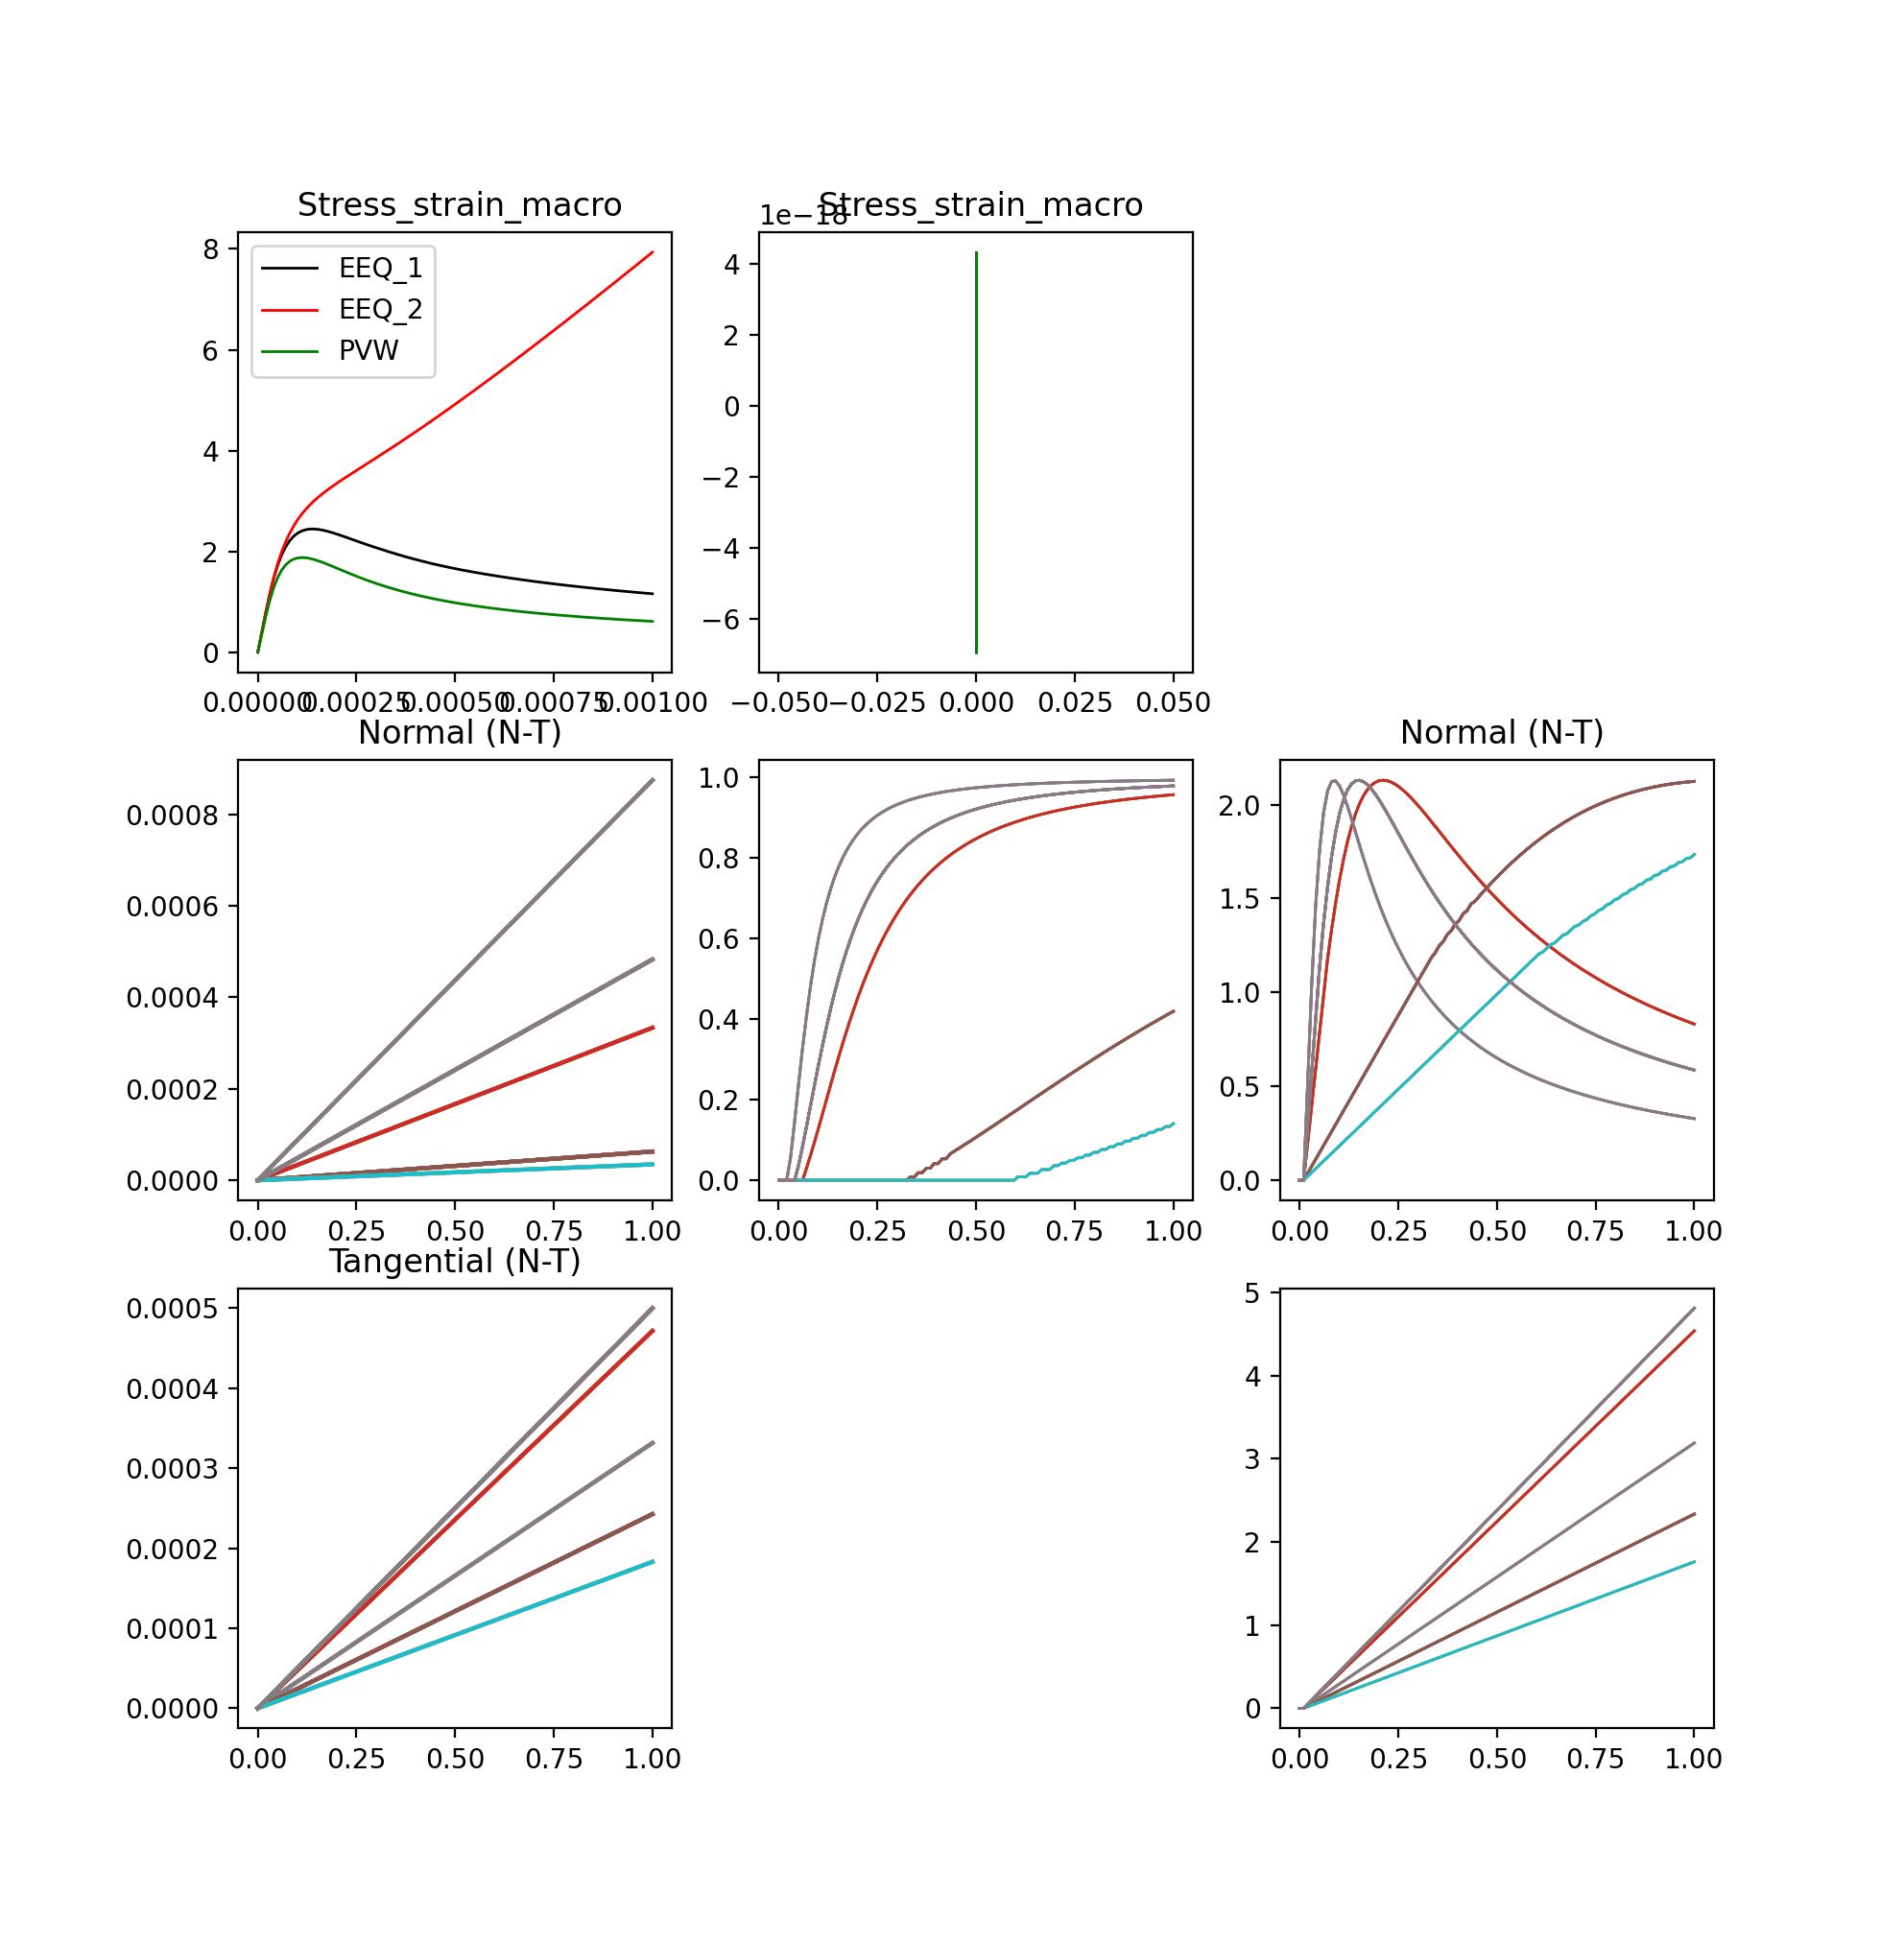

In [16]:
n = 100
s_levels = linspace(0, 0.001, 2)
s_levels[0] = 0
s_levels.reshape(-1, 2)[:, 0] *= 0
#s_levels.reshape(-1, 2)[:, 1] *= -1
s_history = s_levels.flatten()
s_arr = hstack([linspace(s_history[i], s_history[i + 1], n)
                for i in range(len(s_levels) - 1)])

# Tensio
eps = array([array([[s_arr[i], 0, 0],
                    [0, 0, 0],
                    [0, 0, 0]]) for i in range(0, len(s_arr))])


# # Shear
# eps = array([array([[0, s_arr[i], 0],
#                     [s_arr[i], 0, 0],
#                     [0, 0, 0]]) for i in range(0, len(s_arr))])

model = MATS3DMicroplane()

# Paramters
model.sigma_T_0 = 200.0
model.Ad = 7000.0
model.eps_0 = 0.00002


n_mp = model.n_mp

sigma_EEQ1 = zeros_like(eps)
sigma_EEQ2 = zeros_like(eps)
sigma_PVW = zeros_like(eps)

sctx = zeros((len(eps[:, 0, 0]) + 1, 28, 9))

omega_N_Emn = zeros((len(eps[:, 0, 0]), 28))
r_N_Emn = zeros((len(eps[:, 0, 0]), 28))
sigma_N_Emn = zeros((len(eps[:, 0, 0]), 28))
eps_T_pi_Emna = zeros((len(eps[:, 0, 0]), 28, 3))
sigma_T_Emna = zeros((len(eps[:, 0, 0]), 28, 3))
eps_N_Emn = zeros((len(eps[:, 0, 0]), 28))
eps_T_Emna = zeros((len(eps[:, 0, 0]), 28, 3))


for i in range(0, len(eps[:, 0, 0])):
    
    sigma_EEQ1[i, :] = model.get_corr_pred_EEQ_1(eps[i, :], sctx[i, :])[0]
    sigma_EEQ2[i, :] = model.get_corr_pred_EEQ_2(eps[i, :], sctx[i, :])[0]
    sigma_PVW[i, :] = model.get_corr_pred_PVW(eps[i, :], sctx[i, :])[0]
    
    sctx[i + 1] = model.get_state_variables( eps[i, :], sctx[i, :])
    
    sigma_N_Emn[i, :] = sctx[i, : , 0]
    omega_N_Emn[i, :] = sctx[i, : , 1]
    r_N_Emn[i, :] = sctx[i, : , 2]
    sigma_T_Emna[i, :] = sctx[i, :, 3:6]
    eps_T_pi_Emna[i, :]  = sctx[i, :, 6:9]
    eps_N_Emn[i, :] = model._get_e_N_arr(eps[i, :])
    eps_T_Emna[i, :, :] = model._get_e_T_vct_arr(eps[i, :])

    
#==============================================================
# Plotting
#==============================================================

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 9.8
fig_size[1] = 10

fig = plt.figure(1)

time = np.linspace(0, 1, len(eps[:, 0]))

ax1 = fig.add_subplot(331)
#for i in range(0, len(eps_1[:, 0])):
ax1.plot(eps[:, 0, 0], sigma_EEQ1[:, 0, 0], linewidth=1, color='black', label='EEQ_1')
ax1.plot(eps[:, 0, 0], sigma_EEQ2[:, 0, 0], linewidth=1, color='red', label='EEQ_2')
ax1.plot(eps[:, 0, 0], sigma_PVW[:, 0, 0], linewidth=1, color='green', label='PVW')
plt.title(' Stress_strain_macro')
plt.legend()


ax1 = fig.add_subplot(332)
#for i in range(0, len(eps_1[:, 0])):
ax1.plot(eps[:, 0, 1], sigma_EEQ1[:, 0, 1], linewidth=1, color='black', label='EEQ_1')
ax1.plot(eps[:, 0, 1], sigma_EEQ2[:, 0, 1], linewidth=1, color='red', label='EEQ_2')
ax1.plot(eps[:, 0, 1], sigma_PVW[:, 0, 1], linewidth=1, color='green', label='PVW')
plt.title(' Stress_strain_macro')


# At microplane level

ax1 = fig.add_subplot(334)
for i in range(0, n_mp):
    ax1.plot(time, eps_N_Emn[:, i])
plt.title(' Normal (N-T)')


ax2 = fig.add_subplot(335)

for i in range(0, 28):
    ax2.plot(time, omega_N_Emn[:, i], linewidth=1, label='omega_N')


ax3 = fig.add_subplot(336)
for i in range(0, 28):
    ax3.plot(time, sigma_N_Emn[:, i], linewidth=1, label='sigma_N') 
plt.title(' Normal (N-T)')
    
 

ax4 = fig.add_subplot(337)
for i in range(0, n_mp):
    norm = sqrt(einsum('...i,...i->... ', eps_T_Emna[:, i], eps_T_Emna[:, i]))
    ax4.plot(time, norm)
plt.title('Tangential (N-T)')


ax5 = fig.add_subplot(339)
for i in range(0, 28):
    norm_sigma_T = einsum('...i,...i->...', sigma_T_Emna[:, i], sigma_T_Emna[:, i])
    ax5.plot(time, np.sqrt(norm_sigma_T), linewidth=1, label='sigma_N')      
plt.show()


<IPython.core.display.Javascript object>


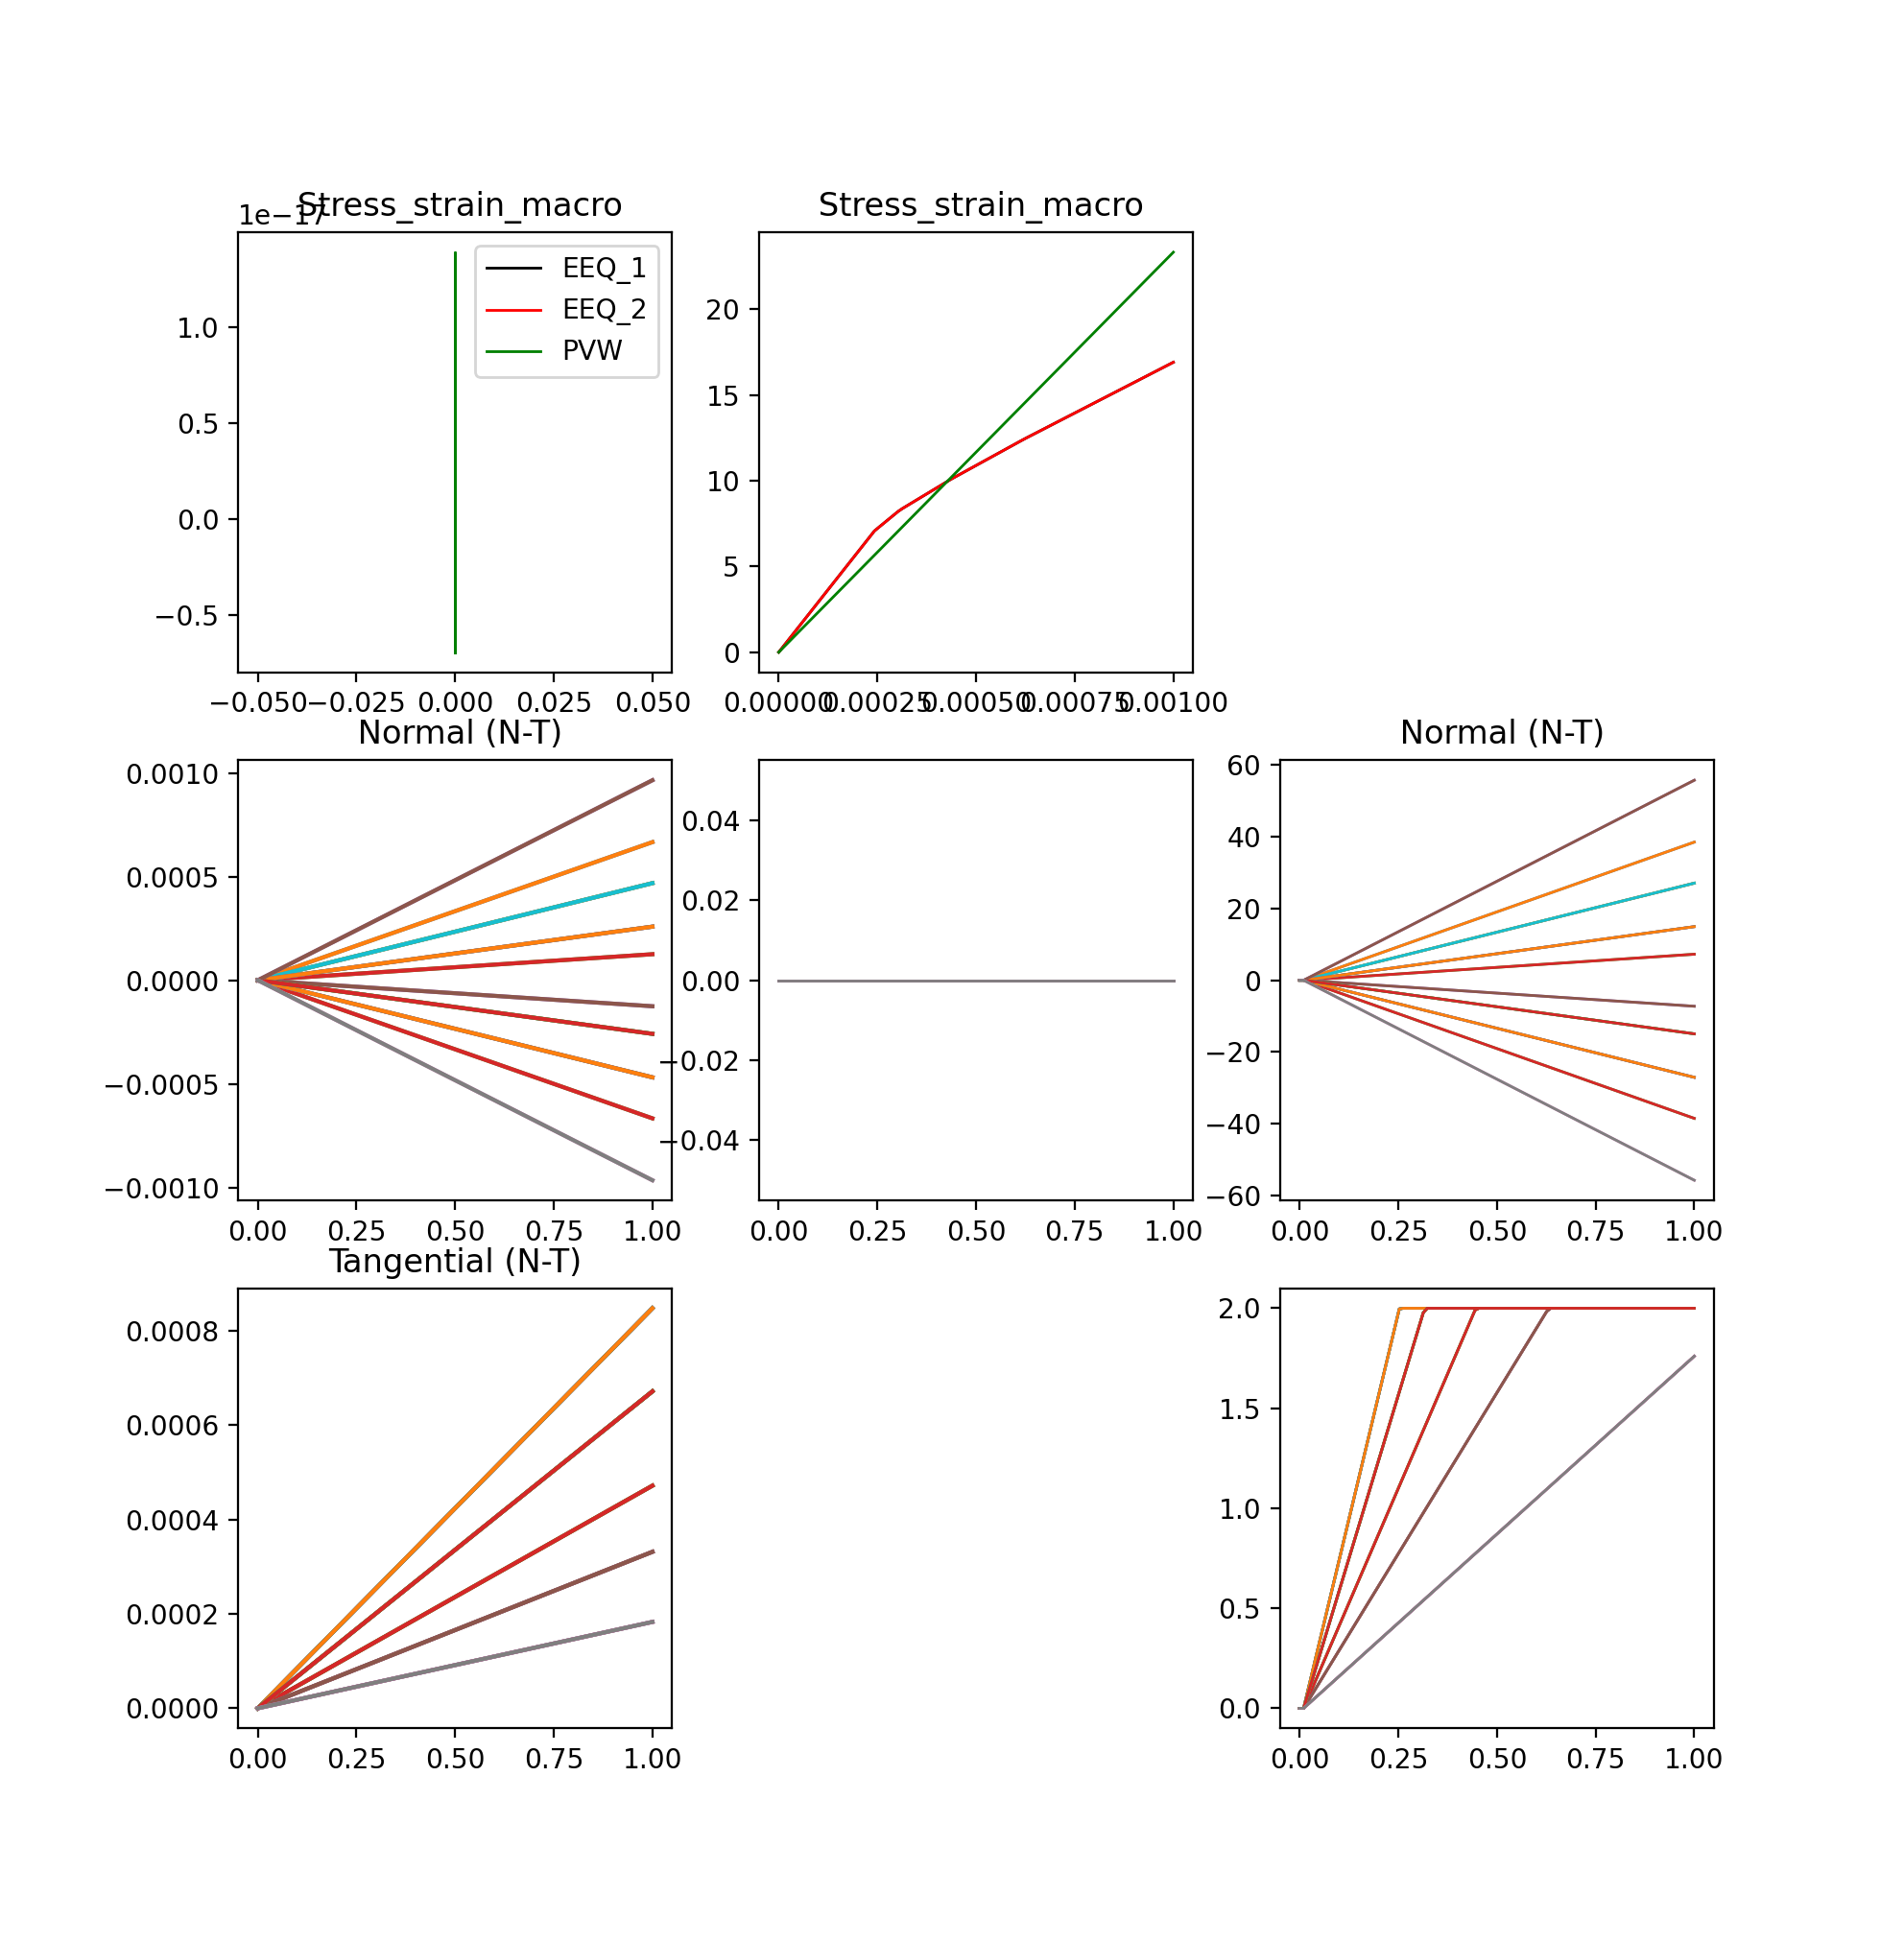

In [17]:
n = 100
s_levels = linspace(0, 0.001, 2)
s_levels[0] = 0
s_levels.reshape(-1, 2)[:, 0] *= 0
#s_levels.reshape(-1, 2)[:, 1] *= -1
s_history = s_levels.flatten()
s_arr = hstack([linspace(s_history[i], s_history[i + 1], n)
                for i in range(len(s_levels) - 1)])

# # Tensio
# eps = array([array([[s_arr[i], 0, 0],
#                     [0, 0, 0],
#                     [0, 0, 0]]) for i in range(0, len(s_arr))])


# Shear
eps = array([array([[0, s_arr[i], 0],
                    [s_arr[i], 0, 0],
                    [0, 0, 0]]) for i in range(0, len(s_arr))])

model = MATS3DMicroplane()

# Paramters
model.sigma_T_0 = 2.0
model.Ad = 7000.0
model.eps_0 = 20.00002


n_mp = model.n_mp

sigma_EEQ1 = zeros_like(eps)
sigma_EEQ2 = zeros_like(eps)
sigma_PVW = zeros_like(eps)

sctx = zeros((len(eps[:, 0, 0]) + 1, 28, 9))

omega_N_Emn = zeros((len(eps[:, 0, 0]), 28))
r_N_Emn = zeros((len(eps[:, 0, 0]), 28))
sigma_N_Emn = zeros((len(eps[:, 0, 0]), 28))
eps_T_pi_Emna = zeros((len(eps[:, 0, 0]), 28, 3))
sigma_T_Emna = zeros((len(eps[:, 0, 0]), 28, 3))
eps_N_Emn = zeros((len(eps[:, 0, 0]), 28))
eps_T_Emna = zeros((len(eps[:, 0, 0]), 28, 3))


for i in range(0, len(eps[:, 0, 0])):
    
    sigma_EEQ1[i, :] = model.get_corr_pred_EEQ_1(eps[i, :], sctx[i, :])[0]
    sigma_EEQ2[i, :] = model.get_corr_pred_EEQ_2(eps[i, :], sctx[i, :])[0]
    sigma_PVW[i, :] = model.get_corr_pred_PVW(eps[i, :], sctx[i, :])[0]
    
    sctx[i + 1] = model.get_state_variables( eps[i, :], sctx[i, :])
    
    sigma_N_Emn[i, :] = sctx[i, : , 0]
    omega_N_Emn[i, :] = sctx[i, : , 1]
    r_N_Emn[i, :] = sctx[i, : , 2]
    sigma_T_Emna[i, :] = sctx[i, :, 3:6]
    eps_T_pi_Emna[i, :]  = sctx[i, :, 6:9]
    eps_N_Emn[i, :] = model._get_e_N_arr(eps[i, :])
    eps_T_Emna[i, :, :] = model._get_e_T_vct_arr(eps[i, :])

    
#==============================================================
# Plotting
#==============================================================

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 9.8
fig_size[1] = 10

fig = plt.figure(2)

time = np.linspace(0, 1, len(eps[:, 0]))

ax1 = fig.add_subplot(331)
#for i in range(0, len(eps_1[:, 0])):
ax1.plot(eps[:, 0, 0], sigma_EEQ1[:, 0, 0], linewidth=1, color='black', label='EEQ_1')
ax1.plot(eps[:, 0, 0], sigma_EEQ2[:, 0, 0], linewidth=1, color='red', label='EEQ_2')
ax1.plot(eps[:, 0, 0], sigma_PVW[:, 0, 0], linewidth=1, color='green', label='PVW')
plt.title(' Stress_strain_macro')
plt.legend()


ax1 = fig.add_subplot(332)
#for i in range(0, len(eps_1[:, 0])):
ax1.plot(eps[:, 0, 1], sigma_EEQ1[:, 0, 1], linewidth=1, color='black', label='EEQ_1')
ax1.plot(eps[:, 0, 1], sigma_EEQ2[:, 0, 1], linewidth=1, color='red', label='EEQ_2')
ax1.plot(eps[:, 0, 1], sigma_PVW[:, 0, 1], linewidth=1, color='green', label='PVW')
plt.title(' Stress_strain_macro')


# At microplane level

ax1 = fig.add_subplot(334)
for i in range(0, n_mp):
    ax1.plot(time, eps_N_Emn[:, i])
plt.title(' Normal (N-T)')


ax2 = fig.add_subplot(335)

for i in range(0, 28):
    ax2.plot(time, omega_N_Emn[:, i], linewidth=1, label='omega_N')


ax3 = fig.add_subplot(336)
for i in range(0, 28):
    ax3.plot(time, sigma_N_Emn[:, i], linewidth=1, label='sigma_N') 
plt.title(' Normal (N-T)')
    
 

ax4 = fig.add_subplot(337)
for i in range(0, n_mp):
    norm = sqrt(einsum('...i,...i->... ', eps_T_Emna[:, i], eps_T_Emna[:, i]))
    ax4.plot(time, norm)
plt.title('Tangential (N-T)')


ax5 = fig.add_subplot(339)
for i in range(0, 28):
    norm_sigma_T = einsum('...i,...i->...', sigma_T_Emna[:, i], sigma_T_Emna[:, i])
    ax5.plot(time, np.sqrt(norm_sigma_T), linewidth=1, label='sigma_N')      
plt.show()


In [19]:
DELTA = np.identity(3)

EPS = np.zeros((3, 3, 3), dtype='f')
EPS[(0, 1, 2), (1, 2, 0), (2, 0, 1)] = 1
EPS[(2, 1, 0), (1, 0, 2), (0, 2, 1)] = -1

DD = np.hstack([DELTA, np.zeros_like(DELTA)])
EEPS = np.hstack([np.zeros_like(EPS), EPS])

GAMMA = np.einsum(
    'ik,jk->kij', DD, DD
) + np.einsum(
    'ikj->kij', np.fabs(EEPS)
)

def get_eps_ab(eps_O): return np.einsum(
    'Oab,...O->...ab', GAMMA, eps_O
)[np.newaxis, ...]

GAMMA_inv = np.einsum(
    'aO,bO->Oab', DD, DD
) + 0.5 * np.einsum(
    'aOb->Oab', np.fabs(EEPS)
)


def get_sig_O(sig_ab): return np.einsum(
    'Oab,...ab->...O', GAMMA_inv, sig_ab
)[0, ...]


GG = np.einsum(
    'Oab,Pcd->OPabcd', GAMMA_inv, GAMMA_inv
)


def get_K_OP(D_abcd):
    return np.einsum(
        'OPabcd,abcd->OP', GG, D_abcd
    )

MPW = np.array([.0160714276, .0160714276, .0160714276, .0160714276, .0204744730,
                     .0204744730, .0204744730, .0204744730, .0204744730, .0204744730,
                     .0204744730, .0204744730, .0204744730, .0204744730, .0204744730,
                     .0204744730, .0158350505, .0158350505, .0158350505, .0158350505,
                     .0158350505, .0158350505, .0158350505, .0158350505, .0158350505,
                     .0158350505, .0158350505, .0158350505]) * 6.0

MPN = np.array([[.577350259, .577350259, .577350259],
                         [.577350259, .577350259, -.577350259],
                         [.577350259, -.577350259, .577350259],
                         [.577350259, -.577350259, -.577350259],
                         [.935113132, .250562787, .250562787],
                         [.935113132, .250562787, -.250562787],
                         [.935113132, -.250562787, .250562787],
                         [.935113132, -.250562787, -.250562787],
                         [.250562787, .935113132, .250562787],
                         [.250562787, .935113132, -.250562787],
                         [.250562787, -.935113132, .250562787],
                         [.250562787, -.935113132, -.250562787],
                         [.250562787, .250562787, .935113132],
                         [.250562787, .250562787, -.935113132],
                         [.250562787, -.250562787, .935113132],
                         [.250562787, -.250562787, -.935113132],
                         [.186156720, .694746614, .694746614],
                         [.186156720, .694746614, -.694746614],
                         [.186156720, -.694746614, .694746614],
                         [.186156720, -.694746614, -.694746614],
                         [.694746614, .186156720, .694746614],
                         [.694746614, .186156720, -.694746614],
                         [.694746614, -.186156720, .694746614],
                         [.694746614, -.186156720, -.694746614],
                         [.694746614, .694746614, .186156720],
                         [.694746614, .694746614, -.186156720],
                         [.694746614, -.694746614, .186156720],
                         [.694746614, -.694746614, -.186156720]])

def get_int_var(int_var, size, n_mp):  # unpacks saved data

#     S = np.zeros((size, n_mp, 30))

#     S[0] = np.array(pd.read_hdf(path, 'first'))

#     for i in range(1, size):
#         S[i] = np.array(pd.read_hdf(path, 'middle' + np.str(i - 1)))
        
    S = int_var
        
        # Definition internal variables / forces per column:  1) damage N, 2)iso N, 3)kin N, 4) consolidation N, 5) eps p N,
        # 6) sigma N, 7) iso F N, 8) kin F N, 9) energy release N, 10) damage T, 11) iso T, 12-14) kin T, 15-17) eps p T,
        # 18-20) sigma T, 21) iso F T, 22-24) kin F T, 25) energy release T, 26) eps_N, 27-29) e_T, 30)R_n

    # @todo: definition of protocols - order should not be defined by indexing
    omega_N_Emn = S[:, :, 0]
    z_N_Emn = S[:, :, 1]
    alpha_N_Emn = S[:, :, 2]
    r_N_Emn = S[:, :, 3]
    eps_N_p_Emn = S[:, :, 4]
    sigma_N_Emn = S[:, :, 5]
    Z_N_Emn = S[:, :, 6]
    X_N_Emn = S[:, :, 7]
    Y_N_Emn = S[:, :, 8]

    omega_T_Emn = S[:, :, 9]
    z_T_Emn = S[:, :, 10]
    alpha_T_Emna = S[:, :, 11:14]
    eps_T_pi_Emna = S[:, :, 14:17]
    sigma_T_Emna = S[:, :, 17:20]
    Z_T_pi_Emn = S[:, :, 20]
    X_T_pi_Emna = S[:, :, 21:24]
    Y_T_pi_Emn = S[:, :, 24]

    eps_N_Emn = S[:, :, 25]
    eps_T_Emna = S[:, :, 26:29]
    R_N_Emn = S[:, :, 29]


    return omega_N_Emn, z_N_Emn, alpha_N_Emn, r_N_Emn, eps_N_p_Emn, sigma_N_Emn, Z_N_Emn, X_N_Emn, Y_N_Emn, \
           omega_T_Emn, z_T_Emn, alpha_T_Emna, eps_T_pi_Emna, sigma_T_Emna, Z_T_pi_Emn, X_T_pi_Emna, Y_T_pi_Emn, \
           eps_N_Emn, eps_T_Emna, R_N_Emn

def get_UF_t_EEQ_1(mats, time_function, n_t):

    int_var = np.zeros((n_mp, 30))
    int_var_accepted = np.zeros((n_mp, 30))
    dissip = np.zeros((n_mp, 8))
    D = np.zeros((3, 3, 3, 3))
    D = D[np.newaxis, :, :, :, :]


    # total number of DOFs
    n_O = 6
    # Global vectors
    F_ext = np.zeros((n_O,), np.float_)
    F_O = np.zeros((n_O,), np.float_)
    U_P = np.zeros((n_O,), np.float_)
    U_k_O = np.zeros((n_O,), dtype=np.float_)
    eps_aux = copy.deepcopy(get_eps_ab(U_k_O))
    eps_p_Emab_aux = get_eps_ab(U_k_O)
    dissip_energy = np.zeros((8,len(time_function)), np.float_)
    # Construct index maps distinguishing the controlled displacements
    # and free displacements. Here we simply say the the control displacement
    # is the first one. Then index maps are constructed using the np.where
    # function returning the indexes of True positions in a logical array.
    CONTROL = 0
    FREE = slice(1, None)  # This means all except the first index, i.e. [1:]
    # Setup the system matrix with displacement constraints
    # Time stepping parameters
    t_n1, t_max, t_step = 0, len(time_function), 1 / n_t
    t_n = 0
    # Iteration parameters
    k_max, R_acc = 1000, 1e-6
    # Record solutions
    U_t_list, F_t_list, U_P_list, dissip_energy_list = [np.copy(U_k_O)], [np.copy(F_O)], \
         [np.copy(U_P)], [np.copy(dissip_energy)]
    energy_loop = []
    energy_loop_damage = []
    energy_loop_plastic = []
    # Initialization
    x_descending = []
    x_ascending = []
    y_descending = []
    y_ascending = []
    F_t_energy = []
    U_t_energy = []
    plastic_energy = []
    damage_energy = []
    dissipated_energy = [0]

    # Load increment loop
    while t_n1 <= t_max-1:
        #print('t:', t_n1)
        # Get the displacement increment for this step
        delta_U = time_function[t_n1] - time_function[t_n]
        k = 0
        # Equilibrium iteration loop
        while k < k_max:
            # Transform the primary vector to field
            eps_ab = get_eps_ab(U_k_O).reshape(3, 3)
            # Stress and material stiffness
            D_abcd, sig_ab, eps_p_Emab = copy.deepcopy(mats.get_corr_pred_EEQ_1(
                eps_ab, 1, int_var, eps_aux, F_ext
            ))
            # Internal force
            F_O = get_sig_O(sig_ab.reshape(1, 3, 3)).reshape(6, )

            # System matrix
            K_OP = get_K_OP(D_abcd)
            #Beta = get_K_OP(beta_Emabcd)
            # Get the balancing forces - NOTE - for more displacements
            # this should be an assembly operator.
            # KU remains a 2-d array so we have to make it a vector
            KU = K_OP[:, CONTROL] * delta_U
            # Residuum
            R_O = F_ext - F_O - KU
            # Convergence criterion
            R_norm = np.linalg.norm(R_O[FREE])

            if R_norm < R_acc:
                # Convergence reached
                break
            # Next iteration -
            delta_U_O = np.linalg.solve(K_OP[FREE, FREE], R_O[FREE])
            U_k_O[FREE] += delta_U_O
            # Update control displacement
            U_k_O[CONTROL] += delta_U
            # Note - control displacement nonzero only in the first iteration.
            delta_U = 0
            k += 1
        else:
            print('no convergence')
            break

        eps_ab =  get_eps_ab(U_k_O).reshape(3, 3)
        int_var = copy.deepcopy(mats._x_get_state_variables(eps_ab, int_var, eps_aux))


        omega_N_Emn_dot = int_var[:, 0] - int_var_accepted[:, 0]
        z_N_Emn_dot = int_var[:, 1] - int_var_accepted[:, 1]
        alpha_N_Emn_dot = int_var[:, 2] - int_var_accepted[:, 2]
        eps_N_p_Emn_dot = int_var[:, 4] - int_var_accepted[:, 4]
        eps_N_Emn_dot = int_var[:, 25] - int_var_accepted[:, 25]
        eps_N_e_Emn_dot = (int_var[:, 25] - int_var[:, 4]) - (int_var_accepted[:, 25] - int_var_accepted[:, 4])
        r_N_Emn_dot = int_var[:, 3] - int_var_accepted[:, 3]

        sigma_N_Emn = int_var[:, 5]
        Z_n = int_var[:, 6]
        X_n = int_var[:, 7]
        Y_n = int_var[:, 8]
        R_n = int_var[:, 29]

        omega_T_Emn_dot = int_var[:, 9] - int_var_accepted[:, 9]
        z_T_Emn_dot = int_var[:, 10] - int_var_accepted[:, 10]
        alpha_T_Emna_dot = int_var[:, 11:14] - int_var_accepted[:, 11:14]
        eps_T_pi_Emna_dot = int_var[:, 14:17] - int_var_accepted[:, 14:17]
        eps_T_Emna_dot = int_var[:, 26:29] - int_var_accepted[:, 26:29]
        eps_T_e_Emna_dot = (int_var[:, 26:29] - int_var[:, 14:17]) - (int_var_accepted[:, 26:29] - int_var_accepted[:, 14:17])

        sigma_T_Emna = int_var[:, 17:20]
        Z_T = int_var[:, 20]
        X_T = int_var[:, 21:24]
        Y_T = int_var[:, 24]

        iso_free_N = np.einsum('...,...->...', Z_n, z_N_Emn_dot)
        kin_free_N = np.einsum('...,...->...', X_n, alpha_N_Emn_dot)
        plast_work_N = np.einsum('...,...->...', sigma_N_Emn, eps_N_p_Emn_dot)
        plast_dissip_N = plast_work_N - iso_free_N - kin_free_N

        iso_free_T = np.einsum('...,...->...', Z_T, z_T_Emn_dot)
        kin_free_T = np.einsum('...n,...n->...', X_T, alpha_T_Emna_dot)
        plast_work_T = np.einsum('...n,...n->...', sigma_T_Emna, eps_T_pi_Emna_dot)
        plast_dissip_T = plast_work_T - iso_free_T - kin_free_T

        plast_diss = np.einsum('...n,...n->...', MPW, plast_dissip_N + plast_dissip_T)
        kin_free = np.einsum('...n,...n->...', MPW, kin_free_N + kin_free_T)
        iso_free = np.einsum('...n,...n->...', MPW, iso_free_N + iso_free_T)

        dissip_energy[0,t_n1] = plast_diss
        dissip_energy[1,t_n1] = kin_free
        dissip_energy[2,t_n1] = iso_free

        damage_diss_N = np.einsum('...,...->...', Y_n, omega_N_Emn_dot) + np.einsum('...,...->...', R_n, r_N_Emn_dot)
        damage_diss_T = np.einsum('...,...->...', Y_T, omega_T_Emn_dot)
        damage_diss = np.einsum('...n,...n->...', MPW, damage_diss_N + damage_diss_T)

        # damage_diss = np.cumsum(damage_diss_N + damage_diss_T)

        dissip_energy[3,t_n1] = damage_diss

        work_micro_N_e = np.einsum('...n,...n->...n', sigma_N_Emn, eps_N_e_Emn_dot)
        work_micro_T_e = np.einsum('...ij,...ij->...i', sigma_T_Emna, eps_T_e_Emna_dot)
        work_micro_e = np.einsum('...n,...n->...', MPW, work_micro_N_e + work_micro_T_e)

        dissip_energy[4,t_n1] = work_micro_e

        work_micro_N = np.einsum('...n,...n->...n', sigma_N_Emn, eps_N_Emn_dot)
        work_micro_T = np.einsum('...ij,...ij->...i', sigma_T_Emna, eps_T_Emna_dot)
        work_micro = np.einsum('...n,...n->...', MPW, work_micro_N + work_micro_T)

        delta = np.identity(3)

        work_macro = np.einsum('...ij,...ij->...', sig_ab, eps_ab - eps_aux)
        work_macro_plast = np.einsum('...ij,...ij->...', sig_ab, eps_p_Emab - eps_p_Emab_aux)
        eps_p_Emab_aux = copy.deepcopy(eps_p_Emab)

        dissip_energy[5,t_n1] = work_micro
        dissip_energy[6,t_n1] = work_macro
        dissip_energy[7, t_n1] = work_macro_plast




        if plast_diss < -1e-5:
            print('second law violation - plast')

        if damage_diss < -1e-5:
            print('second law violation - damage')

        int_var_accepted = copy.deepcopy(int_var)


        U_t_list.append(np.copy(U_k_O))
        F_t_list.append(F_O)
        U_P_list.append(U_P)
        eps_aux = copy.deepcopy(get_eps_ab(U_k_O))
        D_aux = D_abcd[np.newaxis, :, :, :, :]
        D = np.concatenate((D, D_aux))

        t_n = t_n1
        t_n1 += 1

    U_t, F_t, U_p, dissip_energy_= np.array(U_t_list), np.array(F_t_list), np.array(U_P_list), np.array(dissip_energy_list)
    return U_t, F_t, D, U_p, dissip_energy

def get_UF_t_EEQ_2(mats, time_function, n_t):

    int_var = np.zeros((n_mp, 30))
    int_var_accepted = np.zeros((n_mp, 30))
    dissip = np.zeros((n_mp, 8))
    save = np.concatenate((int_var, dissip), axis=1)
    D = np.zeros((3, 3, 3, 3))
    D = D[np.newaxis, :, :, :, :]

    # total number of DOFs
    n_O = 6
    # Global vectors
    F_ext = np.zeros((n_O,), np.float_)
    F_O = np.zeros((n_O,), np.float_)
    U_P = np.zeros((n_O,), np.float_)
    U_k_O = np.zeros((n_O,), dtype=np.float_)
    eps_aux = copy.deepcopy(get_eps_ab(U_k_O))
    eps_p_Emab_aux = get_eps_ab(U_k_O)
    dissip_energy = np.zeros((8,len(time_function)), np.float_)
    # Construct index maps distinguishing the controlled displacements
    # and free displacements. Here we simply say the the control displacement
    # is the first one. Then index maps are constructed using the np.where
    # function returning the indexes of True positions in a logical array.
    CONTROL = 0
    FREE = slice(1, None)  # This means all except the first index, i.e. [1:]
    # Setup the system matrix with displacement constraints
    # Time stepping parameters
    t_n1, t_max, t_step = 0, len(time_function), 1 / n_t
    t_n = 0
    # Iteration parameters
    k_max, R_acc = 1000, 1e-6
    # Record solutions
    U_t_list, F_t_list, U_P_list, dissip_energy_list = [np.copy(U_k_O)], [np.copy(F_O)], \
         [np.copy(U_P)], [np.copy(dissip_energy)]
    energy_loop = []
    energy_loop_damage = []
    energy_loop_plastic = []
    # Initialization
    x_descending = []
    x_ascending = []
    y_descending = []
    y_ascending = []
    F_t_energy = []
    U_t_energy = []
    plastic_energy = []
    damage_energy = []
    dissipated_energy = [0]

    # Load increment loop
    while t_n1 <= t_max-1:
        #print('t:', t_n1)
        # Get the displacement increment for this step
        delta_U = time_function[t_n1] - time_function[t_n]
        k = 0
        # Equilibrium iteration loop
        while k < k_max:
            # Transform the primary vector to field
            eps_ab = get_eps_ab(U_k_O).reshape(3, 3)
            # Stress and material stiffness
            D_abcd, sig_ab, eps_p_Emab = copy.deepcopy(mats.get_corr_pred_EEQ_2(
                eps_ab, 1, int_var, eps_aux, F_ext
            ))
            # Internal force
            F_O = get_sig_O(sig_ab.reshape(1, 3, 3)).reshape(6, )

            # System matrix
            K_OP = get_K_OP(D_abcd)
            #Beta = get_K_OP(beta_Emabcd)
            # Get the balancing forces - NOTE - for more displacements
            # this should be an assembly operator.
            # KU remains a 2-d array so we have to make it a vector
            KU = K_OP[:, CONTROL] * delta_U
            # Residuum
            R_O = F_ext - F_O - KU
            # Convergence criterion
            R_norm = np.linalg.norm(R_O[FREE])

            if R_norm < R_acc:
                # Convergence reached
                break
            # Next iteration -
            delta_U_O = np.linalg.solve(K_OP[FREE, FREE], R_O[FREE])
            U_k_O[FREE] += delta_U_O
            # Update control displacement
            U_k_O[CONTROL] += delta_U
            # Note - control displacement nonzero only in the first iteration.
            delta_U = 0
            k += 1
        else:
            print('no convergence')
            break

        eps_ab =  get_eps_ab(U_k_O).reshape(3, 3)
        int_var = copy.deepcopy(mats._x_get_state_variables(eps_ab, int_var, eps_aux))


        omega_N_Emn_dot = int_var[:, 0] - int_var_accepted[:, 0]
        z_N_Emn_dot = int_var[:, 1] - int_var_accepted[:, 1]
        alpha_N_Emn_dot = int_var[:, 2] - int_var_accepted[:, 2]
        eps_N_p_Emn_dot = int_var[:, 4] - int_var_accepted[:, 4]
        eps_N_Emn_dot = int_var[:, 25] - int_var_accepted[:, 25]
        eps_N_e_Emn_dot = (int_var[:, 25] - int_var[:, 4]) - (int_var_accepted[:, 25] - int_var_accepted[:, 4])
        r_N_Emn_dot = int_var[:, 3] - int_var_accepted[:, 3]

        sigma_N_Emn = int_var[:, 5]
        Z_n = int_var[:, 6]
        X_n = int_var[:, 7]
        Y_n = int_var[:, 8]
        R_n = int_var[:, 29]

        omega_T_Emn_dot = int_var[:, 9] - int_var_accepted[:, 9]
        z_T_Emn_dot = int_var[:, 10] - int_var_accepted[:, 10]
        alpha_T_Emna_dot = int_var[:, 11:14] - int_var_accepted[:, 11:14]
        eps_T_pi_Emna_dot = int_var[:, 14:17] - int_var_accepted[:, 14:17]
        eps_T_Emna_dot = int_var[:, 26:29] - int_var_accepted[:, 26:29]
        eps_T_e_Emna_dot = (int_var[:, 26:29] - int_var[:, 14:17]) - (int_var_accepted[:, 26:29] - int_var_accepted[:, 14:17])

        sigma_T_Emna = int_var[:, 17:20]
        Z_T = int_var[:, 20]
        X_T = int_var[:, 21:24]
        Y_T = int_var[:, 24]

        iso_free_N = np.einsum('...,...->...', Z_n, z_N_Emn_dot)
        kin_free_N = np.einsum('...,...->...', X_n, alpha_N_Emn_dot)
        plast_work_N = np.einsum('...,...->...', sigma_N_Emn, eps_N_p_Emn_dot)
        plast_dissip_N = plast_work_N - iso_free_N - kin_free_N

        iso_free_T = np.einsum('...,...->...', Z_T, z_T_Emn_dot)
        kin_free_T = np.einsum('...n,...n->...', X_T, alpha_T_Emna_dot)
        plast_work_T = np.einsum('...n,...n->...', sigma_T_Emna, eps_T_pi_Emna_dot)
        plast_dissip_T = plast_work_T - iso_free_T - kin_free_T

        plast_diss = np.einsum('...n,...n->...', MPW, plast_dissip_N + plast_dissip_T)
        kin_free = np.einsum('...n,...n->...', MPW, kin_free_N + kin_free_T)
        iso_free = np.einsum('...n,...n->...', MPW, iso_free_N + iso_free_T)

        dissip_energy[0,t_n1] = plast_diss
        dissip_energy[1,t_n1] = kin_free
        dissip_energy[2,t_n1] = iso_free

        damage_diss_N = np.einsum('...,...->...', Y_n, omega_N_Emn_dot) + np.einsum('...,...->...', R_n, r_N_Emn_dot)
        damage_diss_T = np.einsum('...,...->...', Y_T, omega_T_Emn_dot)
        damage_diss = np.einsum('...n,...n->...', MPW, damage_diss_N + damage_diss_T)

        # damage_diss = np.cumsum(damage_diss_N + damage_diss_T)

        dissip_energy[3,t_n1] = damage_diss

        work_micro_N_e = np.einsum('...n,...n->...n', sigma_N_Emn, eps_N_e_Emn_dot)
        work_micro_T_e = np.einsum('...ij,...ij->...i', sigma_T_Emna, eps_T_e_Emna_dot)
        work_micro_e = np.einsum('...n,...n->...', MPW, work_micro_N_e + work_micro_T_e)

        dissip_energy[4,t_n1] = work_micro_e

        work_micro_N = np.einsum('...n,...n->...n', sigma_N_Emn, eps_N_Emn_dot)
        work_micro_T = np.einsum('...ij,...ij->...i', sigma_T_Emna, eps_T_Emna_dot)
        work_micro = np.einsum('...n,...n->...', MPW, work_micro_N + work_micro_T)

        delta = np.identity(3)

        work_macro = np.einsum('...ij,...ij->...', sig_ab, eps_ab - eps_aux)
        work_macro_plast = np.einsum('...ij,...ij->...', sig_ab, eps_p_Emab - eps_p_Emab_aux)
        eps_p_Emab_aux = copy.deepcopy(eps_p_Emab)

        dissip_energy[5,t_n1] = work_micro
        dissip_energy[6,t_n1] = work_macro
        dissip_energy[7, t_n1] = work_macro_plast




        if plast_diss < -1e-5:
            print('second law violation - plast')

        if damage_diss < -1e-5:
            print('second law violation - damage')

        int_var_accepted = copy.deepcopy(int_var)


        U_t_list.append(np.copy(U_k_O))
        F_t_list.append(F_O)
        U_P_list.append(U_P)
        eps_aux = copy.deepcopy(get_eps_ab(U_k_O))
        D_aux = D_abcd[np.newaxis, :, :, :, :]
        D = np.concatenate((D, D_aux))

        t_n = t_n1
        t_n1 += 1

    U_t, F_t, U_p, dissip_energy_= np.array(U_t_list), np.array(F_t_list), np.array(U_P_list), np.array(dissip_energy_list)
    return U_t, F_t, D, U_p, dissip_energy

def get_UF_t_PVW(mats, time_function, n_t):

    int_var = np.zeros((n_mp, 30))
    int_var_accepted = np.zeros((n_mp, 30))
    dissip = np.zeros((n_mp, 8))
    save = np.concatenate((int_var, dissip), axis=1)
    D = np.zeros((3, 3, 3, 3))
    D = D[np.newaxis, :, :, :, :]
    
#     home_dir = os.path.expanduser('~')

#     if not os.path.exists('Data Processing'):
#         os.makedirs('Data Processing')

#     path = os.path.join(
#        home_dir, 'Data Processing',
#        'Prueba' + '.hdf5')
        
#     df = pd.DataFrame(int_var)
#     df.to_hdf(path, 'first', mode='w', format='table')

    # total number of DOFs
    n_O = 6
    # Global vectors
    F_ext = np.zeros((n_O,), np.float_)
    F_O = np.zeros((n_O,), np.float_)
    U_P = np.zeros((n_O,), np.float_)
    U_k_O = np.zeros((n_O,), dtype=np.float_)
    eps_aux = copy.deepcopy(get_eps_ab(U_k_O))
    eps_p_Emab_aux = get_eps_ab(U_k_O)
    dissip_energy = np.zeros((8,len(time_function)), np.float_)
    # Construct index maps distinguishing the controlled displacements
    # and free displacements. Here we simply say the the control displacement
    # is the first one. Then index maps are constructed using the np.where
    # function returning the indexes of True positions in a logical array.
    CONTROL = 0
    FREE = slice(1, None)  # This means all except the first index, i.e. [1:]
    # Setup the system matrix with displacement constraints
    # Time stepping parameters
    t_n1, t_max, t_step = 0, len(time_function), 1 / n_t
    t_n = 0
    # Iteration parameters
    k_max, R_acc = 1000, 1e-6
    # Record solutions
    U_t_list, F_t_list, U_P_list, dissip_energy_list, int_var_list = [np.copy(U_k_O)], [np.copy(F_O)], \
         [np.copy(U_P)], [np.copy(dissip_energy)], [np.copy(int_var)]
    energy_loop = []
    energy_loop_damage = []
    energy_loop_plastic = []
    # Initialization
    x_descending = []
    x_ascending = []
    y_descending = []
    y_ascending = []
    F_t_energy = []
    U_t_energy = []
    plastic_energy = []
    damage_energy = []
    dissipated_energy = [0]

    # Load increment loop
    while t_n1 <= t_max-1:
        #print('t:', t_n1)
        # Get the displacement increment for this step
        delta_U = time_function[t_n1] - time_function[t_n]
        k = 0
        # Equilibrium iteration loop
        while k < k_max:
            # Transform the primary vector to field
            eps_ab = get_eps_ab(U_k_O).reshape(3, 3)
            # Stress and material stiffness
            D_abcd, sig_ab, eps_p_Emab = copy.deepcopy(mats.get_corr_pred_PVW(
                eps_ab, 1, int_var, eps_aux, F_ext
            ))
            # Internal force
            F_O = get_sig_O(sig_ab.reshape(1, 3, 3)).reshape(6, )

            # System matrix
            K_OP = get_K_OP(D_abcd)
            #Beta = get_K_OP(beta_Emabcd)
            # Get the balancing forces - NOTE - for more displacements
            # this should be an assembly operator.
            # KU remains a 2-d array so we have to make it a vector
            KU = K_OP[:, CONTROL] * delta_U
            # Residuum
            R_O = F_ext - F_O - KU
            # Convergence criterion
            R_norm = np.linalg.norm(R_O[FREE])

            if R_norm < R_acc:
                # Convergence reached
                break
            # Next iteration -
            delta_U_O = np.linalg.solve(K_OP[FREE, FREE], R_O[FREE])
            U_k_O[FREE] += delta_U_O
            # Update control displacement
            U_k_O[CONTROL] += delta_U
            # Note - control displacement nonzero only in the first iteration.
            delta_U = 0
            k += 1
        else:
            print('no convergence')
            break

        eps_ab =  get_eps_ab(U_k_O).reshape(3, 3)
        int_var = copy.deepcopy(mats._x_get_state_variables(eps_ab, int_var, eps_aux))


        omega_N_Emn_dot = int_var[:, 0] - int_var_accepted[:, 0]
        z_N_Emn_dot = int_var[:, 1] - int_var_accepted[:, 1]
        alpha_N_Emn_dot = int_var[:, 2] - int_var_accepted[:, 2]
        eps_N_p_Emn_dot = int_var[:, 4] - int_var_accepted[:, 4]
        eps_N_Emn_dot = int_var[:, 25] - int_var_accepted[:, 25]
        eps_N_e_Emn_dot = (int_var[:, 25] - int_var[:, 4]) - (int_var_accepted[:, 25] - int_var_accepted[:, 4])
        r_N_Emn_dot = int_var[:, 3] - int_var_accepted[:, 3]

        sigma_N_Emn = int_var[:, 5]
        Z_n = int_var[:, 6]
        X_n = int_var[:, 7]
        Y_n = int_var[:, 8]
        R_n = int_var[:, 29]

        omega_T_Emn_dot = int_var[:, 9] - int_var_accepted[:, 9]
        z_T_Emn_dot = int_var[:, 10] - int_var_accepted[:, 10]
        alpha_T_Emna_dot = int_var[:, 11:14] - int_var_accepted[:, 11:14]
        eps_T_pi_Emna_dot = int_var[:, 14:17] - int_var_accepted[:, 14:17]
        eps_T_Emna_dot = int_var[:, 26:29] - int_var_accepted[:, 26:29]
        eps_T_e_Emna_dot = (int_var[:, 26:29] - int_var[:, 14:17]) - (int_var_accepted[:, 26:29] - int_var_accepted[:, 14:17])

        sigma_T_Emna = int_var[:, 17:20]
        Z_T = int_var[:, 20]
        X_T = int_var[:, 21:24]
        Y_T = int_var[:, 24]

        iso_free_N = np.einsum('...,...->...', Z_n, z_N_Emn_dot)
        kin_free_N = np.einsum('...,...->...', X_n, alpha_N_Emn_dot)
        plast_work_N = np.einsum('...,...->...', sigma_N_Emn, eps_N_p_Emn_dot)
        plast_dissip_N = plast_work_N - iso_free_N - kin_free_N

        iso_free_T = np.einsum('...,...->...', Z_T, z_T_Emn_dot)
        kin_free_T = np.einsum('...n,...n->...', X_T, alpha_T_Emna_dot)
        plast_work_T = np.einsum('...n,...n->...', sigma_T_Emna, eps_T_pi_Emna_dot)
        plast_dissip_T = plast_work_T - iso_free_T - kin_free_T

        plast_diss = np.einsum('...n,...n->...', MPW, plast_dissip_N + plast_dissip_T)
        kin_free = np.einsum('...n,...n->...', MPW, kin_free_N + kin_free_T)
        iso_free = np.einsum('...n,...n->...', MPW, iso_free_N + iso_free_T)

        dissip_energy[0,t_n1] = plast_diss
        dissip_energy[1,t_n1] = kin_free
        dissip_energy[2,t_n1] = iso_free

        damage_diss_N = np.einsum('...,...->...', Y_n, omega_N_Emn_dot) + np.einsum('...,...->...', R_n, r_N_Emn_dot)
        damage_diss_T = np.einsum('...,...->...', Y_T, omega_T_Emn_dot)
        damage_diss = np.einsum('...n,...n->...', MPW, damage_diss_N + damage_diss_T)

        # damage_diss = np.cumsum(damage_diss_N + damage_diss_T)

        dissip_energy[3,t_n1] = damage_diss

        work_micro_N_e = np.einsum('...n,...n->...n', sigma_N_Emn, eps_N_e_Emn_dot)
        work_micro_T_e = np.einsum('...ij,...ij->...i', sigma_T_Emna, eps_T_e_Emna_dot)
        work_micro_e = np.einsum('...n,...n->...', MPW, work_micro_N_e + work_micro_T_e)

        dissip_energy[4,t_n1] = work_micro_e

        work_micro_N = np.einsum('...n,...n->...n', sigma_N_Emn, eps_N_Emn_dot)
        work_micro_T = np.einsum('...ij,...ij->...i', sigma_T_Emna, eps_T_Emna_dot)
        work_micro = np.einsum('...n,...n->...', MPW, work_micro_N + work_micro_T)

        delta = np.identity(3)

        work_macro = np.einsum('...ij,...ij->...', sig_ab, eps_ab - eps_aux)
        work_macro_plast = np.einsum('...ij,...ij->...', sig_ab, eps_p_Emab - eps_p_Emab_aux)
        eps_p_Emab_aux = copy.deepcopy(eps_p_Emab)

        dissip_energy[5,t_n1] = work_micro
        dissip_energy[6,t_n1] = work_macro
        dissip_energy[7, t_n1] = work_macro_plast




        if plast_diss < -1e-5:
            print('second law violation - plast')

        if damage_diss < -1e-5:
            print('second law violation - damage')

        int_var_accepted = copy.deepcopy(int_var)
        
#         df = pd.DataFrame(int_var_accepted)
#         df.to_hdf(path, 'middle' + np.str(t_n1), append=True)

        int_var_list.append(np.copy(int_var_accepted))
        U_t_list.append(np.copy(U_k_O))
        F_t_list.append(F_O)
        U_P_list.append(U_P)
        eps_aux = copy.deepcopy(get_eps_ab(U_k_O))
        D_aux = D_abcd[np.newaxis, :, :, :, :]
        D = np.concatenate((D, D_aux))

        t_n = t_n1
        t_n1 += 1

    U_t, F_t, U_p, dissip_energy_, int_var = np.array(U_t_list), np.array(F_t_list), np.array(U_P_list), np.array(dissip_energy_list), np.array(int_var_list)
    return U_t, F_t, D, U_p, dissip_energy, int_var

In [20]:
t_steps = 100
n_mp = 28

eps = 0.001

load = np.linspace(0, eps, t_steps)

t_steps = len(load)

ms1 = MATS3DMplCSDEEQ()

U_EEQ_1, F_EEQ_1, D, U_p, dissip_energy  = get_UF_t_EEQ_1(
    ms1,
    load,
    t_steps
)

U_EEQ_2, F_EEQ_2, D, U_p, dissip_energy  = get_UF_t_EEQ_2(
    ms1,
    load,
    t_steps
)

U__PVW, F__PVW, D, U_p, dissip_energy, int_var  = get_UF_t_PVW(
    ms1,
    load,
    t_steps
)




<IPython.core.display.Javascript object>


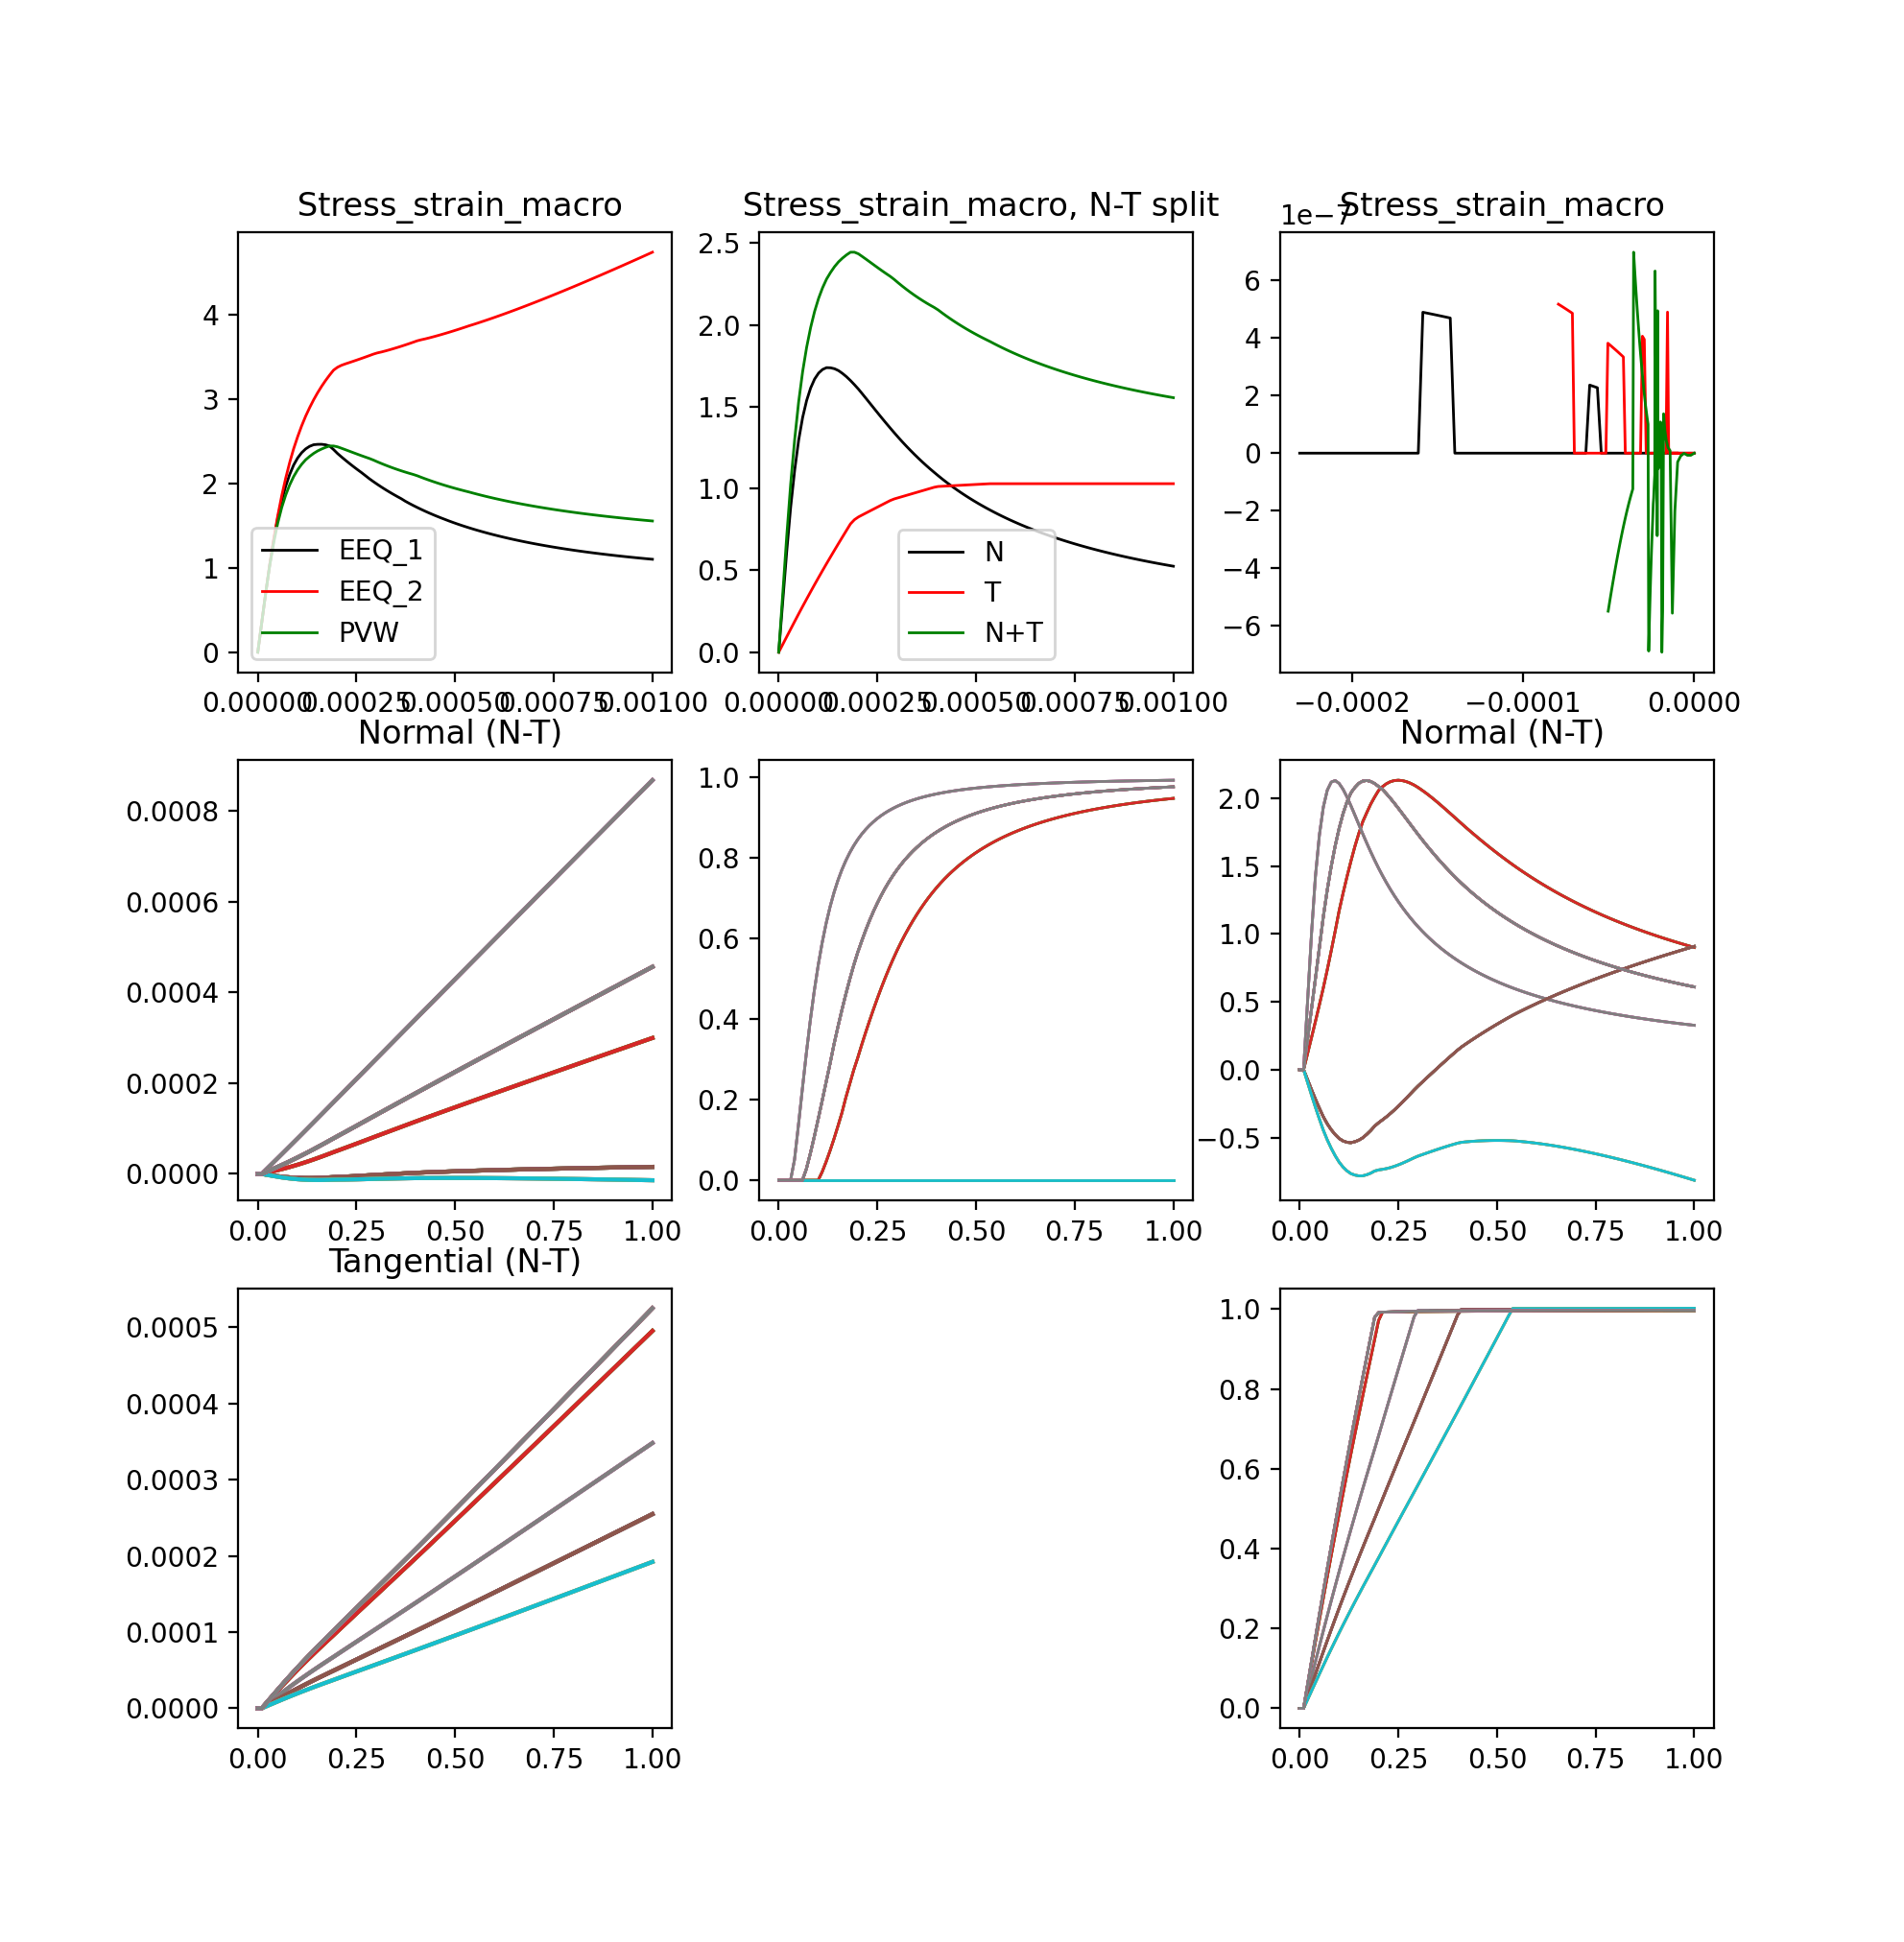

In [21]:
[omega_N_Emn, z_N_Emn, alpha_N_Emn, r_N_Emn, eps_N_p_Emn, sigma_N_Emn, Z_N_Emn, X_N_Emn, Y_N_Emn, \
           omega_T_Emn, z_T_Emn, alpha_T_Emna, eps_T_pi_Emna, sigma_T_Emna, Z_T_pi_Emn, X_T_pi_Emna, Y_T_pi_Emn, \
           eps_N_Emn, eps_T_Emna, R_N_Emn] \
    = get_int_var(int_var, len(F__PVW), n_mp)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 9.8
fig_size[1] = 10

sig_Emab_N = (
        np.einsum('n,...n,na,nb->...ab',
                  MPW, sigma_N_Emn, MPN, MPN) 

)

sig_Emab_T = (
        0.5 * (
                np.einsum('n,...nf,na,fb->...ab',
                          MPW, sigma_T_Emna, MPN, DELTA) +
                np.einsum('n,...nf,nb,fa->...ab', MPW,
                          sigma_T_Emna, MPN, DELTA)
        )
)

fig = plt.figure(3)

time = np.linspace(0, 1, len(U_EEQ_1[:, 0]))

ax1 = fig.add_subplot(331)
#for i in range(0, len(eps_1[:, 0])):
ax1.plot(U_EEQ_1[:, 0], F_EEQ_1[:, 0], linewidth=1, color='black', label='EEQ_1')
ax1.plot(U_EEQ_2[:, 0], F_EEQ_2[:, 0], linewidth=1, color='red', label='EEQ_2')
ax1.plot(U__PVW[:, 0], F__PVW[:, 0], linewidth=1, color='green', label='PVW')
plt.title(' Stress_strain_macro')
plt.legend()

ax1 = fig.add_subplot(332)
#for i in range(0, len(eps_1[:, 0])):
ax1.plot(U_EEQ_1[:, 0], sig_Emab_N[:, 0, 0], linewidth=1, color='black', label='N')
ax1.plot(U_EEQ_2[:, 0], sig_Emab_T[:, 0, 0], linewidth=1, color='red', label='T')
ax1.plot(U__PVW[:, 0], sig_Emab_T[:, 0, 0] + sig_Emab_N[:, 0, 0], linewidth=1, color='green', label='N+T')
plt.title(' Stress_strain_macro, N-T split')
plt.legend()


ax1 = fig.add_subplot(333)
#for i in range(0, len(eps_1[:, 0])):
ax1.plot(U_EEQ_1[:, 1], F_EEQ_1[:, 1], linewidth=1, color='black', label='EEQ_1')
ax1.plot(U_EEQ_2[:, 1], F_EEQ_2[:, 1], linewidth=1, color='red', label='EEQ_2')
ax1.plot(U__PVW[:, 1], F__PVW[:, 1], linewidth=1, color='green', label='PVW')
plt.title(' Stress_strain_macro')


# # At microplane level

ax1 = fig.add_subplot(334)
for i in range(0, n_mp):
    ax1.plot(time, eps_N_Emn[:, i])
plt.title(' Normal (N-T)')


ax2 = fig.add_subplot(335)

for i in range(0, 28):
    ax2.plot(time, omega_N_Emn[:, i], linewidth=1, label='omega_N')


ax3 = fig.add_subplot(336)
for i in range(0, 28):
    ax3.plot(time, sigma_N_Emn[:, i], linewidth=1, label='sigma_N') 
plt.title(' Normal (N-T)')
    
 

ax4 = fig.add_subplot(337)
for i in range(0, n_mp):
    norm = sqrt(einsum('...i,...i->... ', eps_T_Emna[:, i], eps_T_Emna[:, i]))
    ax4.plot(time, norm)
plt.title('Tangential (N-T)')


ax5 = fig.add_subplot(339)
for i in range(0, 28):
    norm_sigma_T = einsum('...i,...i->...', sigma_T_Emna[:, i], sigma_T_Emna[:, i])
    ax5.plot(time, np.sqrt(norm_sigma_T), linewidth=1, label='sigma_N')      
plt.show()